#Imports


In [ ]:
!pip install py-tsdata
!pip install statsmodels==0.12.1
!pip install plotly

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import scipy
from scipy import stats
from tsdata.raw import available_data, load_data
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.graphics.gofplots import qqplot
from numpy import mean
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import plotly.graph_objects as go
import plotly.express as px
from pylab import rcParams
import warnings 
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 15, 6
sns.set_style('darkgrid')

# Functions
Some functions for using in the tasks

In [ ]:
# Function for basic time series plot using plotly
def plot(df, series_name, title=''):
  layout=go.Layout(title=f'Visualization for {title} time series', xaxis=dict(title='Date'), yaxis=dict(title=series_name))
  fig = go.Figure([go.Scatter(x=df.index, y=df[series_name])], layout=layout)
  fig.update_layout(title_x=0.5)
  fig.show();

In [ ]:
# Function for complex time series plot using plotly
def complex_plot(train_df, test_df, series_name,  title='', pred=None, add_pred=False, add_drift=False, x=None, y=None):  
  fig1 = go.Figure([go.Scatter(x=train_df.index, y=train_df[series_name], name='Train')])
  fig2 = go.Figure([go.Scatter(x=test_df.index, y=test_df[series_name], name='Test', mode='lines')])
  data_all=fig1.data+fig2.data

  # if this condition true -> prediction plot is added to test part
  if add_pred:
    fig3 = go.Figure([go.Scatter(x=test_df.index, y=pred, name='Predicted', mode='lines')])
    data_all=fig1.data+fig2.data+fig3.data

  # if this condition true -> dashed line for drift is added 
  if add_drift:
    fig4 = go.Figure([go.Scatter(x=x, y=y, name='Drift', mode='lines', line={'dash':'dash', 'color':'green'})])
    data_all=fig1.data+fig2.data+fig3.data+fig4.data

  layout=go.Layout(title=f'Visualization for {title} time series', xaxis=dict(title='Date'), yaxis=dict(title=series_name))
  fig3 = go.Figure(data=data_all, layout=layout)
  fig3.update_layout(title_x=0.5)
  fig3.show();

In [ ]:
# Helper function for splitting years and quarters string
def split_data(series):
  years = []
  quarters = []
  for s in series:
      years_quarters = str(s).split(' ') 
      years.append(years_quarters[0])
      quarters.append(years_quarters[1])
  return years, quarters

# Function for converting year Q string format to datetime index
def replace_quarters_to_date_index(df, series):
  df['years'], df['quarters'] = split_data(series) # creating columns with years and quarters

  vals_to_replace = {'Q1':'03', 'Q2':'06', 'Q3':'09', 'Q4':'12'} 
  df.quarters = df.quarters.map(vals_to_replace) # replacing quarters with correct values

  df['date']=df.years+df.quarters # combining years and quarters values
  df['date']=pd.to_datetime(df['date'], format='%Y%m')
  df.set_index('date', inplace=True) # setting datetime index

  df['years']=df['years'].astype(int) # converting year to integer for future using it in seasonal plot
  return df

In [ ]:
# Helper function for adding seasonal naive forecast, returns series
def seasonal_naive_forecast(series, seasonal_period, forecast_horizon):

     if len(series) < seasonal_period:
         raise Error("There must be at least 'seasonal_period' observations")
     prev_season = series.iloc[-seasonal_period:]
     season_number = int(np.ceil(forecast_horizon/seasonal_period))
     next_seasons = np.tile(prev_season, season_number)
     
     return pd.Series(next_seasons[:forecast_horizon])

# Function for adding seasonal naive series to dataframe
def add_snaive_forecast(df_test, train_series, seasonal_period, forecast_horizon):
  snaive = pd.DataFrame(seasonal_naive_forecast(train_series, seasonal_period, forecast_horizon))
  snaive.set_index(df_test.index, inplace=True)
  df_test['SNaive']=snaive
  return df_test

In [ ]:
# Function for adding naive forecast to dataframe
def add_naive_forecast(df_test, train_series):
  naive = train_series[-1]
  df_test['Naive']=naive
  return df_test

In [ ]:
# Function for adding average forecast to dataframe
def add_average_forecast(df_test, train_series):
  average = train_series.mean()
  df_test['Average']=average
  return df_test

In [ ]:
# Helper function to calculate drift method values
def drift_fc(train, test):
  slope = (train[-1]-train[0])/(len(train)-1)
  values=[]
  fc=1
  for i in range(len(test)):
    value=train[-1]+fc*slope
    values.append(value)
    fc=fc+1
  return values

# Function for adding drift forecast to dataframe
def add_drift_forecast(df_test, train_series, test_series):
  drift = drift_fc(train_series, test_series)
  df_test['Drift']=drift
  return df_test

In [ ]:
# Combining all benchmarks methods to one dataframe
def add_benchmark_methods(df_test, train, test, seasonal_period):
  df_test = add_average_forecast(df_test, train)
  df_test = add_naive_forecast(df_test, train)
  df_test = add_snaive_forecast(df_test, train, seasonal_period, len(test))
  df_test = add_drift_forecast(df_test, train, test)
  return df_test

In [ ]:
# Function for calculating MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Helper function for calculating main metrics
def metrics(true, predicted):
  mape = round(mean_absolute_percentage_error(true, predicted), 2)
  mae = round(mean_absolute_error(true, predicted), 2)
  rmse = round(np.sqrt(mean_squared_error(true, predicted)), 2)
  metrics_series=[mae, mape, rmse]
  return metrics_series

# Function for returning dataframe with calculated metrics for the benchmark methods
def metrics_frame(true, df_methods):
  results=pd.DataFrame(index=['MAE', 'MAPE', 'RMSE'])
  results['SNaive']=metrics(true, df_methods.SNaive)
  results['Naive']=metrics(true, df_methods.Naive)
  results['Average']=metrics(true, df_methods.Average)
  results['Drift']=metrics(true, df_methods.Drift)
  return results

# Function for printing all main metrics, used with plots
def print_metrics(true, predicted):
  m=metrics(true, predicted)
  print('MAPE:', m[1])
  print('MAE:', m[0])
  print('RMSE:', m[2])

In [ ]:
# Helper function for residual plots: basic plot, histogram, ACF plot
def plot_residual_analysis(residuals, lags, bins):
  residuals.plot(linestyle='--', marker='o') 
  plt.axhline(y = 0, color ="green", linestyle ="--")
  plt.show()
  residuals.hist(bins=bins)
  plot_acf(residuals);

# helper function for adding residuals column to dataframe
def add_residuals(actual, predicted, df_test):
  df_test['Residuals']=actual-predicted
  return df_test

# Combining 2 previous functions together into one for checking residuals
def check_residuals(actual, predicted, df_test, lags=24, bins=30):
  df_test=add_residuals(actual, predicted, df_test)
  plot_residual_analysis(df_test.Residuals, lags=lags, bins=bins)

In [ ]:
# Function for scatter plot of fitted values vs residuals
def scatter_fitted_vs_residuals(fitted, residuals, title=''):
  plt.scatter(x=fitted,y=residuals)
  xmin=min(fitted)
  xmax = max(fitted)
  plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--')
  plt.xlabel("Fitted values",fontsize=15)
  plt.ylabel("Residuals",fontsize=15)
  plt.title(f"Fitted {title} vs residuals plot",fontsize=18)
  plt.show();

In [ ]:
# Function for QQ plot of the residuals
def qq_plot(residuals, title=''):  
  qqplot(residuals, line='45', fit='True')
  plt.xlabel("Theoretical quantiles",fontsize=15)
  plt.ylabel("Sample quantiles",fontsize=15)
  plt.title(f"Q-Q plot of {title} residuals",fontsize=18)
  plt.show();

# Ex 1
Produce forecasts for the following series using whichever of NAIVE(y), SNAIVE(y) or RW(y ~ drift()) is more appropriate in each case:

## a. Australian Population (global_economy)

In [ ]:
#Reading the data
df1_a = load_data("global_economy")
df1_a = df1_a[df1_a.Country=='Australia'][['Year', 'Population']]
df1_a.head()

,Year,Population
638,1960,10276477.0
639,1961,10483000.0
640,1962,10742000.0
641,1963,10950000.0
642,1964,11167000.0


In [ ]:
# Setting year as datetime index
df1_a.Year=pd.to_datetime(df1_a.Year, format='%Y')
df1_a.set_index('Year', inplace=True)

In [ ]:
#Visualization fot time series
plot(df1_a, 'Population', 'Australian population')

From the plot we can see that data is very close to straight upward line, so drift method can produce really good forecast in such case.

There are no suggestion in the task how to split the data on train and test, so I just took last five years as test.  

For all next tasks also not always was mentioned how to split test/train so I just took some few years of data as test.

In [ ]:
# Splitting on train/test, creating drift forecast and plotting the data
df1_a_test=df1_a[-5:]
df1_a_train=df1_a[:-5]
df1_a_test = add_drift_forecast(df1_a_test, df1_a_train.Population, df1_a_test.Population)
print_metrics(df1_a_test.Population, df1_a_test.Drift)
complex_plot(df1_a_train, df1_a_test, 'Population', 'population', pred=df1_a_test.Drift, add_pred=True)

MAPE: 1.66
MAE: 400445.81
RMSE: 435901.81


Drift method gave us good result, close to actual values and small MAPE.

## b. Bricks (aus_production)

In [ ]:
#Reading the data
df1_b = load_data("aus_production")
df1_b = df1_b[['Quarter', 'Bricks']]
df1_b

,Quarter,Bricks
0,1956 Q1,189.0
1,1956 Q2,204.0
2,1956 Q3,208.0
3,1956 Q4,197.0
4,1957 Q1,187.0
...,...,...
213,2009 Q2,NaN
214,2009 Q3,NaN
215,2009 Q4,NaN
216,2010 Q1,NaN


Here we need to change Quarter to datetime index. And also there are some nan values, let's check them in more details.

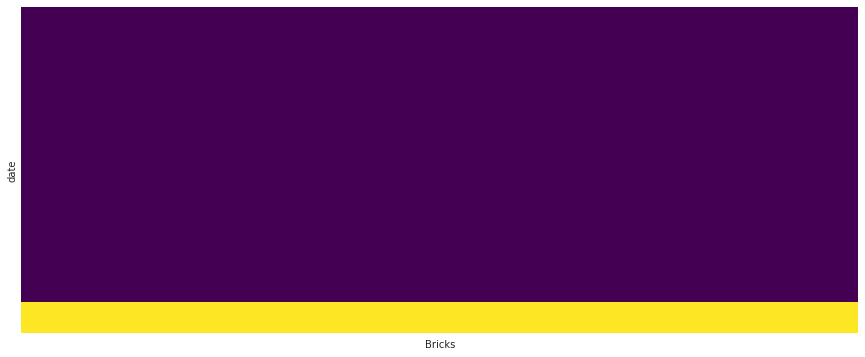

In [ ]:
# Visualization of 'unknown' values
df1_b = replace_quarters_to_date_index(df1_b, df1_b.Quarter)[['Bricks']]
sns.heatmap(df1_b.isnull(),cbar=False,yticklabels=False,cmap = 'viridis');

Nans are last values, we can just drop them.

In [ ]:
# Dropping NaN rows
df1_b.dropna(inplace=True)

In [ ]:
# Visualization for the time series
plot(df1_b, 'Bricks', 'bricks production')

In this data we can see yearly seasonality, so SNaive is the best choice in this case. Also there is some kind of 5 years cycle/trend, so I took the data from last 5 years for prediction. 

In [ ]:
# Splitting on train/test, creating Seasonal naive forecast and plotting the data
df1_b_train=df1_b[:-20]
df1_b_test=df1_b[-20:]
df1_b_test=add_snaive_forecast(df1_b_test, df1_b_train.Bricks, 20, len(df1_b_test.Bricks))
print_metrics(df1_b_test.Bricks, df1_b_test.SNaive)
complex_plot(df1_b_train, df1_b_test, 'Bricks', pred=df1_b_test.SNaive, add_pred=True)

MAPE: 4.88
MAE: 19.0
RMSE: 24.49


As we can see prediction is very close to actual because of repeated seasonality. 

## c. NSW Lambs (aus_livestock)

In [ ]:
#Reading the data
df1_c = load_data("aus_livestock")
df1_c = df1_c.query('(State == "New South Wales") and (Animal == "Lambs")')
df1_c = df1_c[['Month', 'Count']]

In [ ]:
# Setting datetime index
df1_c.Month = pd.to_datetime(df1_c.Month, format='%Y %b')
df1_c.set_index('Month', inplace=True)

In [ ]:
# Visualization for the time series
plot(df1_c, 'Count', 'lambs count')

Time series has some not clear seasonality, but more looks like random walk so I decided to use Naive method here.

In [ ]:
# Splitting on train/test, creating Naive forecast and plotting the data
df1_c_train=df1_c[:-36]
df1_c_test=df1_c[-36:]
df1_c_test=add_naive_forecast(df1_c_test, df1_c_train.Count)
print_metrics(df1_c_test.Count, df1_c_test.Naive)
complex_plot(df1_c_train, df1_c_test, 'Count', 'lambs count', pred=df1_c_test.Naive, add_pred=True)

MAPE: 8.17
MAE: 34008.33
RMSE: 42842.54


As we can see this prediction is good enough, not perfect of course, but in this case it is acceptable as for such simple method MAPE is pretty small.

##d. Household wealth (hh_budget)

In [ ]:
#Reading the data
df1_d = load_data("hh_budget")
df1_d = df1_d[df1_d.Country=='USA'][['Year', 'Wealth']]
df1_d.head()

,Year,Wealth
66,1995,472.3219
67,1996,484.8396
68,1997,510.1932
69,1998,527.0515
70,1999,562.7451


In [ ]:
# Setting year as datetime index
df1_d.Year=pd.to_datetime(df1_d.Year, format='%Y')
df1_d.set_index('Year', inplace=True)

In [ ]:
# Visualization for the time series
plot(df1_d, 'Wealth', 'household wealth')

In this case it is hard to decide which method to select as data doesn't have clear seasonality, just some cycles. Most probably there is upward trend so I pick Drift method for this case to be able to catch this trend. But quality of prediction depends a lot on the last train observation we have - is it on the peak or on the trough. 

In [ ]:
# Splitting on train/test, creating Naive forecast and plotting the data
df1_d_train=df1_d[:-3]
df1_d_test=df1_d[-3:]
df1_d_test=add_drift_forecast(df1_d_test, df1_d_train.Wealth, df1_d_test.Wealth)
print_metrics(df1_d_test.Wealth, df1_d_test.Drift)
complex_plot(df1_d_train, df1_d_test, 'Wealth', 'household wealth', pred=df1_d_test.Drift, add_pred=True)

MAPE: 1.31
MAE: 7.73
RMSE: 10.39


In the case of such test/train split Drift method prediction is pretty good and has small MAPE.

##e. Australian takeaway food turnover (aus_retail)

In [ ]:
#Reading the data
df1_e = load_data("aus_retail")
df1_e = df1_e[df1_e.Industry=='Takeaway food services']
df1_e

,State,Industry,Series ID,Month,Turnover
8379,Australian Capital Territory,Takeaway food services,A3349850K,1982 Apr,3.2
8380,Australian Capital Territory,Takeaway food services,A3349850K,1982 May,3.3
8381,Australian Capital Territory,Takeaway food services,A3349850K,1982 Jun,3.5
8382,Australian Capital Territory,Takeaway food services,A3349850K,1982 Jul,3.5
8383,Australian Capital Territory,Takeaway food services,A3349850K,1982 Aug,3.7
...,...,...,...,...,...
64527,Western Australia,Takeaway food services,A3349435A,2018 Aug,178.5
64528,Western Australia,Takeaway food services,A3349435A,2018 Sep,179.8
64529,Western Australia,Takeaway food services,A3349435A,2018 Oct,183.2
64530,Western Australia,Takeaway food services,A3349435A,2018 Nov,183.7


In [ ]:
# Setting the datetime index
df1_e.Month = pd.to_datetime(df1_e.Month, format='%Y %b')
df1_e.set_index('Month', inplace=True)

As we have in the task to check Australian turnover, so all states turnovers were grouped based on the date

In [ ]:
# Grouping and visualizing the time series
gr =df1_e.groupby(level=0).sum()
plot(gr, 'Turnover', 'takeaway food turnover')

Here we can see yearly seasonality which is changing over time but in the last years it is almost the same. Also we have upward trend here. I think SNaive can give us good result in such case.

In [ ]:
# Splitting on train/test, creating Seasonal naive forecast and plotting the data
df1_e_train=gr[:-36]
df1_e_test=gr[-36:]
df1_e_test=add_snaive_forecast(df1_e_test, df1_e_train.Turnover, 12, len(df1_e_test.Turnover))
print_metrics(df1_e_test.Turnover, df1_e_test.SNaive)
complex_plot(df1_e_train, df1_e_test, 'Turnover', 'takeaway food turnover', pred=df1_e_test.SNaive, add_pred=True)

MAPE: 10.02
MAE: 153.65
RMSE: 160.13


As we can see result could be better if we could take trend into account, but it's not within this task

# Ex 2
Use the Facebook stock price (data set gafa_stock) to do the following:

In [ ]:
# Reading the data
df2 = load_data("gafa_stock")
df2=df2[df2.Symbol=='FB']
df2.head()

,Symbol,Date,Open,High,Low,Close,Adj_Close,Volume
2516,FB,2014-01-02,54.830002,55.220001,54.189999,54.709999,54.709999,43195500
2517,FB,2014-01-03,55.020000,55.650002,54.529999,54.560001,54.560001,38246200
2518,FB,2014-01-06,54.419998,57.259998,54.049999,57.200001,57.200001,68852600
2519,FB,2014-01-07,57.700001,58.549999,57.220001,57.919998,57.919998,77207400
2520,FB,2014-01-08,57.599998,58.410000,57.230000,58.230000,58.230000,56682400


## a
Produce a time plot of the series.

In [ ]:
# Setting datetime index and plotting the time series
df2.Date=pd.to_datetime(df2.Date)
df2.set_index('Date', inplace=True)
plot(df2, 'Adj_Close', 'facebook stock price')

## b
Produce forecasts using the drift method and plot them.

In [ ]:
# Splitting onto train/test 
df2_train=df2[:-48]
df2_test=df2[-48:]

# Creating Drift forecast and visualizing the data
df2_test=add_drift_forecast(df2_test, df2_train.Adj_Close, df2_test.Adj_Close)
x=[df2_train.index[0], df2_train.index[-1]]
y=[df2_train.Adj_Close[0], df2_train.Adj_Close[-1]]
print_metrics(df2_test.Adj_Close, df2_test.Drift)
complex_plot(df2_train, df2_test, 'Adj_Close', 'facebook stock price', pred=df2_test.Drift, add_pred=True, add_drift=True, x=x, y=y)

MAPE: 10.97
MAE: 15.01
RMSE: 17.05


##c
Show that the forecasts are identical to extending the line drawn between the first and last observations.

Was done in b already

## d
Try using some of the other benchmark functions to forecast the same data set. Which do you think is best? Why?

I will use Naive forecast as other benchmark function because data doesn't follow any pattern, no clear seasonality, changing trend, so Naive is best and easy option in this case.

In [ ]:
# Creating Naive forecast and plotting the data
df2_test=add_naive_forecast(df2_test, df2_train.Adj_Close)
print_metrics(df2_test.Adj_Close, df2_test.Naive)
complex_plot(df2_train, df2_test, 'Adj_Close', 'facebook stock price', pred=df2_test.Naive, add_pred=True)

MAPE: 9.51
MAE: 13.01
RMSE: 14.87


We can see that MAPE for Naive method is smaller then for Drift as we have changing trend and Naive is neutral to this, but Drift will produce forecast with upward trend.

# Ex 3
Apply a seasonal naïve method to the quarterly Australian beer production data from 1992. Check if the residuals look like white noise, and plot the forecasts. The following code will help.

Extract data of interest
recent_production <- aus_production %>%
  filter(year(Quarter) >= 1992)

Define and estimate a model
fit <- recent_production %>% model(SNAIVE(Beer))

Look at the residuals
fit %>% gg_tsresiduals()

Look a some forecasts
fit %>% forecast() %>% autoplot(recent_production)

What do you conclude?

In [ ]:
# Reading the data, setting indexes and splitting train/test
df3 = load_data("aus_production")
df3 = replace_quarters_to_date_index(df3, df3.Quarter)[['Beer']]
df3_test = df3[df3.index.year>1991]
df3_train = df3[df3.index.year<1992]

In [ ]:
# Adding seasonal naive forecast, metrics and visualization for it
df3_test = add_snaive_forecast(df3_test, df3_train.Beer, 4, len(df3_test.Beer))
print_metrics(df3_test.Beer, df3_test.SNaive)
complex_plot(df3_train, df3_test, 'Beer', 'bear production', pred=df3_test.SNaive, add_pred=True)

MAPE: 9.09
MAE: 40.16
RMSE: 46.38


We can see that seasonal changes were captured good with this method but still forecast is not accurate enough. Let's check the residuals. To repeat R's gg_tsresiduals() function function with similar 3 plots were done: residuals plot, residuals histogram, ACF plot of the residuals.

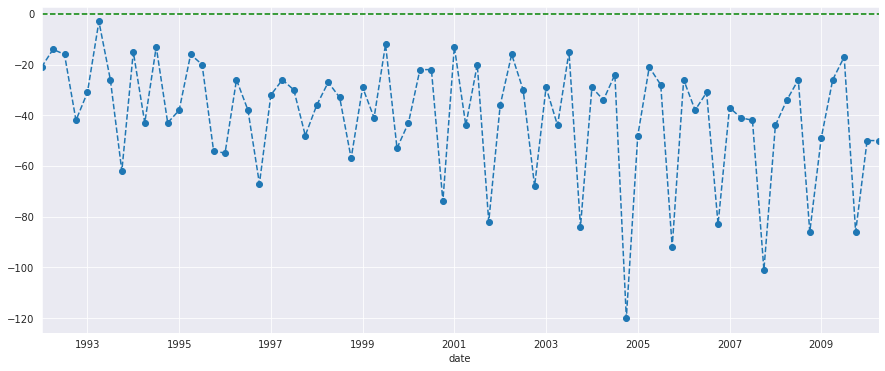

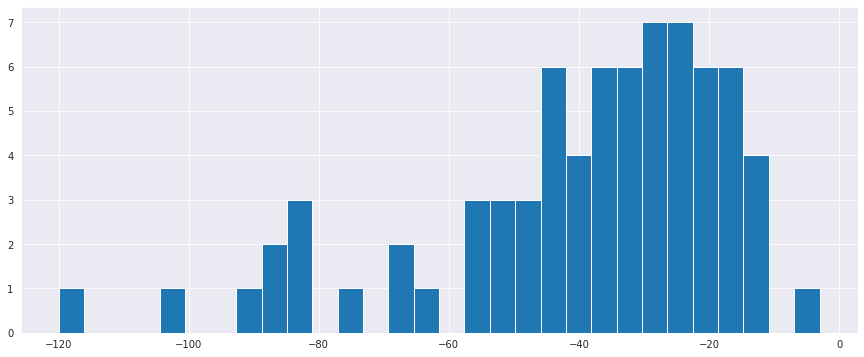

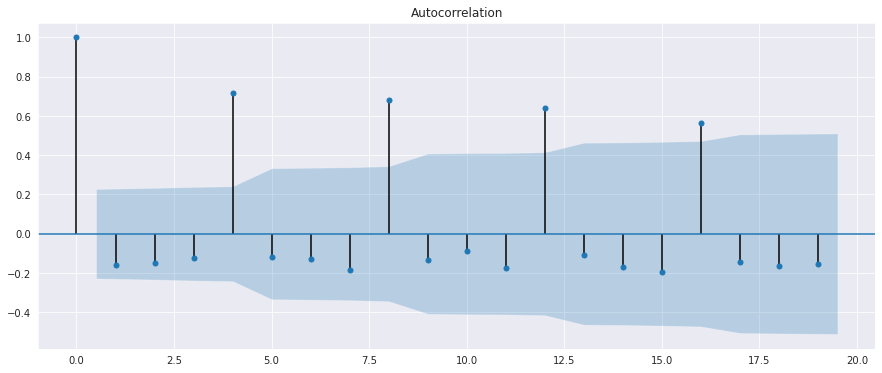

In [ ]:
# Visualization for the residuals
check_residuals(df3_test.Beer, df3_test.SNaive, df3_test)

Here from the first plot we can see that forecast is biased and residuals not randomly distributed around zero mean. Bias can be fixed by substracting residuals mean from the forecast (at least I will try and check if it helps). Also we can see clear autocorrelation on the ACF plot, so still not all seasonal patterns were extracted. Histogram also doesn't follow normal distribution pattern.

In [ ]:
# Eliminating bias of the residuals and checking the new prediction
df3_test['Unbiased_snaive']=df3_test.SNaive-np.abs(df3_test.Residuals.mean())
print_metrics(df3_test.Beer, df3_test.Unbiased_snaive)
complex_plot(df3_train, df3_test, 'Beer', 'beer production', pred=df3_test.Unbiased_snaive, add_pred=True)

MAPE: 3.95
MAE: 17.59
RMSE: 23.19


Metrics and visualization shows more accurate forecast now. Let's check how the residuals look like.

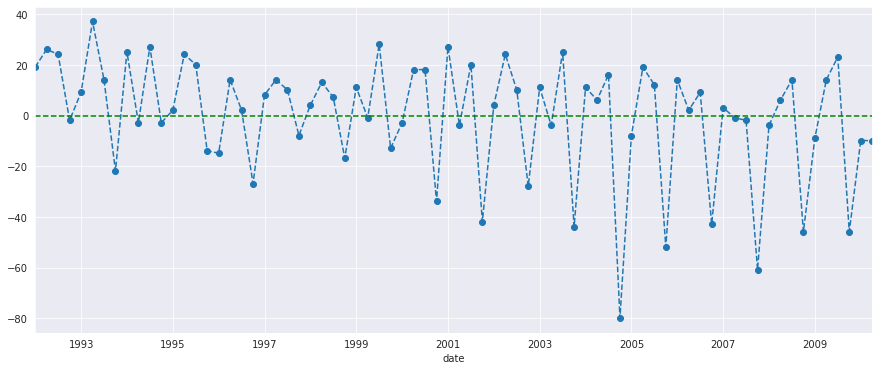

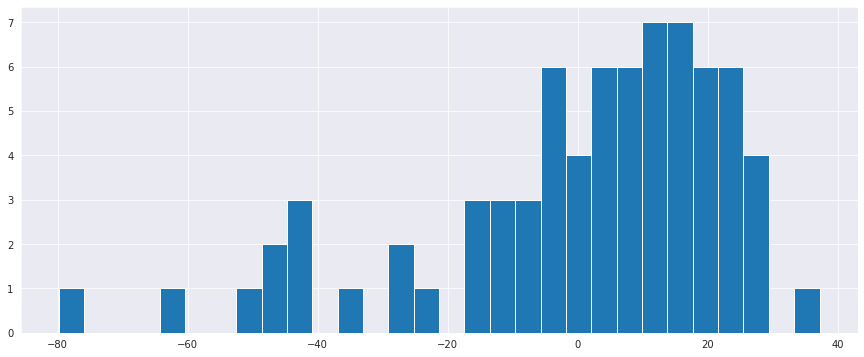

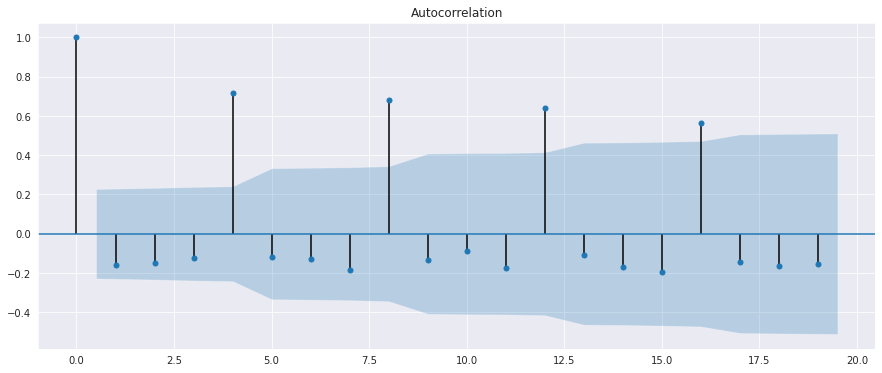

In [ ]:
# Checking new residuals
check_residuals(df3_test.Beer, df3_test.Unbiased_snaive, df3_test)

As we can see after changes residuals are better distributed around zero but still no normal distribution and the same autocorrelation of the residuals exists, so this model needs improvements.

# Ex 4
Repeat the previous exercise using the Australian Exports series from global_economy and the Bricks series from aus_production. Use whichever of NAIVE() or SNAIVE() is more appropriate in each case.

## a Australian Exports series (global_economy)

In [ ]:
# Filtering the data for one series ID
df4_a = load_data('global_economy')
df4_a = df4_a[df4_a['Country'] == 'Australia']
df4_a.head()

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
638,Australia,AUS,1960,1.857319e+10,NaN,7.960458,14.061746,12.994452,10276477.0
639,Australia,AUS,1961,1.964834e+10,2.485605,8.142560,15.025080,12.403101,10483000.0
640,Australia,AUS,1962,1.988801e+10,1.296478,8.116545,12.630927,13.943012,10742000.0
641,Australia,AUS,1963,2.150185e+10,6.214278,8.168574,13.834054,13.005886,10950000.0
642,Australia,AUS,1964,2.375854e+10,6.978724,8.402706,13.764495,14.938248,11167000.0


In [ ]:
# Setting datetime index
df4_a.Year = pd.to_datetime(df4_a.Year, format='%Y')
df4_a.set_index('Year', inplace=True)

In [ ]:
# Visualization of the time series
plot(df4_a, 'Exports', 'Australian Exports')

In this case I think Naive is more appropriate as data doesn't have some clear seasonality, it has peaks and troughs but they are not repeating over time. 

In [ ]:
# Splitting on train/test
df4_a_train=df4_a[df4_a.index.year<2011]
df4_a_test=df4_a[df4_a.index.year>2010]

# Adding Naive method forecast and plotting the data, metrics
df4_a_test=add_naive_forecast(df4_a_test, df4_a_train.Exports)
print_metrics(df4_a_test.Exports, df4_a_test.Naive)
complex_plot(df4_a_train, df4_a_test, 'Exports', 'Australian Exports', pred=df4_a_test.Naive, add_pred=True)

MAPE: 4.66
MAE: 0.98
RMSE: 1.16


As we can see Naive gave us acceptable result in this case.

## b Bricks series (aus_production)-> the same as 1.b exercise

In [ ]:
# Checking the data
df4_b = df1_b.copy() 
df4_b.head()

,Bricks
date,
1956-03-01,189.0
1956-06-01,204.0
1956-09-01,208.0
1956-12-01,197.0
1957-03-01,187.0


In [ ]:
# Visualization for the time series
plot(df4_b, 'Bricks', 'bricks production')

We already were examining this data in task 1, but here I want to check smaller seasonality (yearly, not 5-yearly). Let's see what seasonality is due to ACF plot.

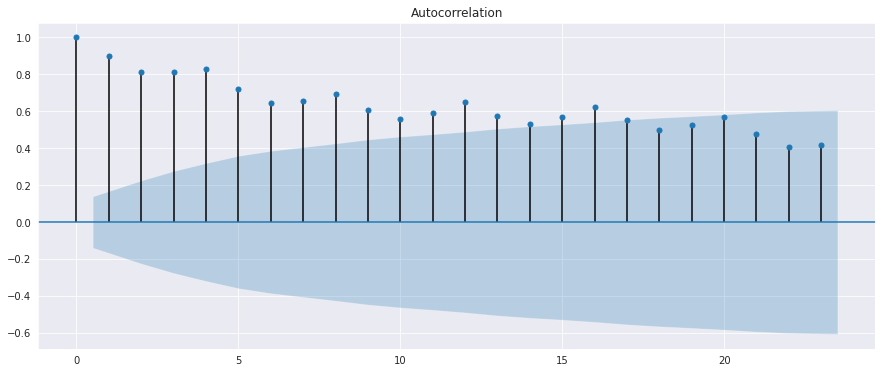

In [ ]:
# ACF plotting for the series
plot_acf(df4_b.Bricks);

From this plot we can see peaks on the 4-th lags, so will set the period for season as 4 and will check the result.

In [ ]:
# Splitting on train/test, creating Seasonal naive forecast and plotting the data
df4_b_train=df4_b[:-20]
df4_b_test=df4_b[-20:]
df4_b_test=add_snaive_forecast(df4_b_test, df4_b_train.Bricks, 4, len(df4_b_test.Bricks))
print_metrics(df4_b_test.Bricks, df4_b_test.SNaive)
complex_plot(df4_b_train, df4_b_test, 'Bricks', 'bricks production', pred=df4_b_test.SNaive, add_pred=True)

MAPE: 9.44
MAE: 34.0
RMSE: 46.56


We can see that forecast is better then Naive could be, but 5-yearly seasonality gave better result. In exercise 1.b MAPE was 4.9 vs 9.4 here.

#Ex 5
Produce forecasts for the 7 Victorian series in aus_livestock using SNAIVE(). Plot the resulting forecasts including the historical data. Is this a reasonable benchmark for these series?

In [ ]:
#Reading the data and setting datetime index
df5= load_data("aus_livestock")
df5 = df5[df5.State == "Victoria"]
df5.Month = pd.to_datetime(df5.Month, format='%Y %b')
df5.set_index('Month', inplace=True)

To be albe forecast all 7 series we need to group them by date

In [ ]:
df5=df5.groupby(level=0).sum()

In [ ]:
# Visualization for the time series
plot(df5, 'Count', 'count livestock')

Most probably we have some seasonality here but it is not really clear, so let's check ACF plot.

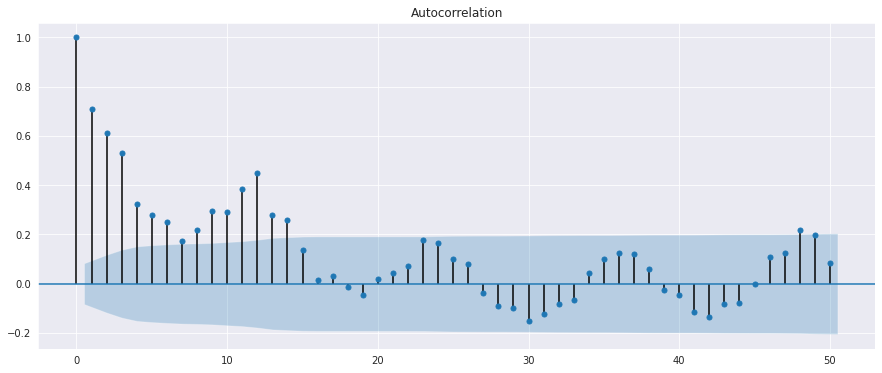

In [ ]:
plot_acf(df5.Count, lags=50);

We can observe yearly seasonality here, so seasonal window would be 12 as we have monthly data.

In [ ]:
# Splitting on train and test sets
df5_train=df5[df5.index.year<2016]
df5_test=df5[df5.index.year>2015]

In [ ]:
# Adding Seasonal naive forecast and checking metrics/visualization
df5_test=add_snaive_forecast(df5_test, df5_train.Count, 12, len(df5_test.Count))
print_metrics(df5_test.Count, df5_test.SNaive)
complex_plot(df5_train, df5_test, 'Count', 'count livestock', pred=df5_test.SNaive, add_pred=True)

MAPE: 9.33
MAE: 142086.11
RMSE: 181543.72


I think this method is not the best here as seasonality is not repeatable over year, there are a lot of changes and data is often random. Simple Naive method could give the same result.

In [ ]:
# Checking forecast with naive method
df5_test=add_naive_forecast(df5_test, df5_train.Count)
print_metrics(df5_test.Count, df5_test.Naive)
complex_plot(df5_train, df5_test, 'Count', 'count livestock', pred=df5_test.Naive, add_pred=True)

MAPE: 9.3
MAE: 147394.44
RMSE: 195788.92


As we can see for this forecast metrics are almost the same, so basically there is no difference which method to apply.

# Ex 6
Are the following statements true or false? Explain your answer.

## a
Good forecast methods should have normally distributed residuals.

False. This is not always the case as with normally distributed residuals prediction is easier, but it is possible to deal with non-normal innovation residuals.

## b
A model with small residuals will give good forecasts.

False. Of course we need the scale of the residuals to be several orders of magnitude less than the scale of the original data, but if residuals are autocorrelated and don't have zero mean it will not be enough.

## c
The best measure of forecast accuracy is MAPE.

False. It depends. MAPE is interpretable and good for comparing, but it assumes the unit of measurement has a meaningful zero which is not always the case. Also if actual values can be zero or close to zero it will give not correct results. And last disadvantage that it puts a heavier penalty on negative errors than on positive errors. So few metrics should be considered sometimes, not only MAPE.

## d
If your model doesn’t forecast well, you should make it more complicated.

False. Complicated models not always generalize good and catch the underlying patterns. They always should be compared to the benchmarks method to understand if the complicated model worth considering.

## e
Always choose the model with the best forecast accuracy as measured on the test set.

True. Better if it will be cross-validated measurement.

# Ex 7
For your retail time series (from Exercise 8 in Section 2.10):

In [ ]:
# Filtering the data for one series ID
df7 = load_data('aus_retail')
df7 = df7[df7['Series ID'] == 'A3349849A']
df7

,State,Industry,Series ID,Month,Turnover
0,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 Apr,4.4
1,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 May,3.4
2,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 Jun,3.6
3,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 Jul,4.0
4,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 Aug,3.6
...,...,...,...,...,...
436,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,2018 Aug,41.7
437,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,2018 Sep,41.4
438,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,2018 Oct,41.7
439,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,2018 Nov,44.0


##a
Create a training dataset consisting of observations before 2011 using (code in R)

In [ ]:
# Setting index as year and month
df7.Month = pd.to_datetime(df7.Month, format='%Y %b')
df7.set_index('Month', inplace=True)

In [ ]:
# Selecting records before 2011 year for train set
df7_train=df7[df7.index.year<2011]

# Selecting records after 2011 year for test set
df7_test=df7[df7.index.year>2010]

##b
Check that your data have been split appropriately by producing the following plot.

autoplot(myseries, Turnover) +
  autolayer(myseries_train, Turnover, colour = "red")

In [ ]:
# Visualization for test/train split of the time series
complex_plot(df7_train, df7_test, 'Turnover', 'retail turnover')

We can see that last 8 years are the test data, all the years before are the train data.

##c
Fit a seasonal naïve model using SNAIVE() applied to your training data (myseries_train).


fit <- myseries_train %>%
  model(SNAIVE())

In [ ]:
# Adding Seasonal naive forecast
df7_test=add_snaive_forecast(df7_test, df7_train.Turnover, 12, len(df7_test.Turnover))

##d
Check the residuals.

fit %>% gg_tsresiduals()
Do the residuals appear to be uncorrelated and normally distributed?

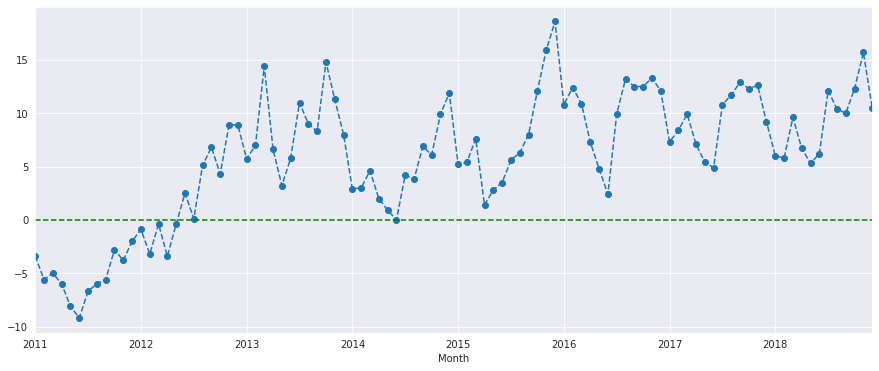

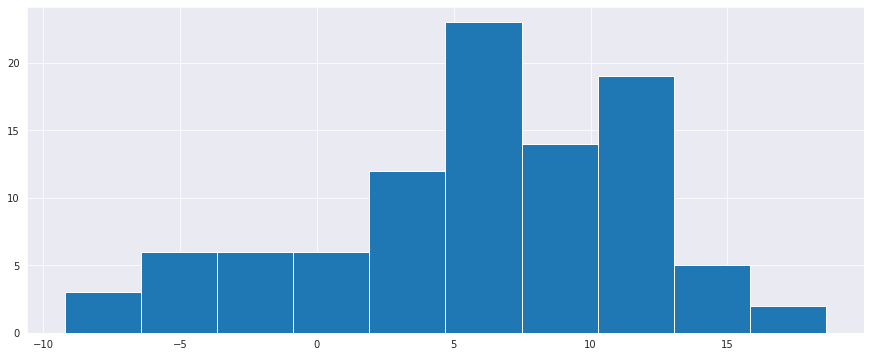

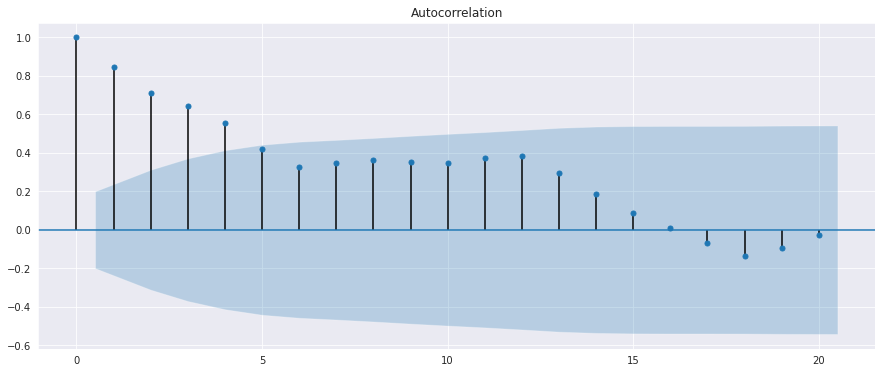

In [ ]:
# Visualization for residuals analysis
check_residuals(df7_test.Turnover, df7_test.SNaive, df7_test, lags=10, bins=10)

From residuals analysis we can see that residuals are not normally distributed around zero mean, and autocorrelation exists for the first few lags. So this model need to be reviewed and improved.

##e
Produce forecasts for the test data

fc <- fit %>%
  forecast(new_data = anti_join(myseries, myseries_train))
fc %>% autoplot(myseries)

In [ ]:
# Visualization for seasonal naive forecast
complex_plot(df7_train, df7_test, 'Turnover', 'retail turnover', pred=df7_test.SNaive, add_pred=True)

We can see that seasonality for this data is not repeated for every year so forecast differs a lot from the actual values.

##f
Compare the accuracy of your forecasts against the actual values.

fit %>% accuracy()
fc %>% accuracy(myseries)

In [ ]:
# Checking metrics for the seasonal naive forecast
print_metrics(df7_test.Turnover, df7_test.SNaive)

MAPE: 19.05
MAE: 7.38
RMSE: 8.42


As we can see from the metrics forecast is not really good because error is almost 20%

## g
How sensitive are the accuracy measures to the amount of training data used?

Actually accuracy measures will not change if train set is smaller from the beginning (for example if we have in train set only 2005-2011 years, or even only 2011 year) as we will use only last year for Seasonal naive forecast. But if to move train/test line to further years then forecast can be better -> it depends on that how similar last train year would be to test data. But anyway we cann't say that the more data we have the better forecast will be. It depends on the pattern which we have in the data and how repeatable it is.

We can check another train/test split to check the answer.

In [ ]:
# Checking Seasonal naive forecast for other train/test split
df7_train=df7[df7.index.year<2014]
df7_test=df7[df7.index.year>2013]
df7_test=add_snaive_forecast(df7_test, df7_train.Turnover, 12, len(df7_test.Turnover))
print_metrics(df7_test.Turnover, df7_test.SNaive)
complex_plot(df7_train, df7_test, 'Turnover', 'retail turnover', pred=df7_test.SNaive, add_pred=True)

MAPE: 7.68
MAE: 3.06
RMSE: 3.85


As we can see in the plot and with the metrics now forecast become much better. It is because 2013 year is much more similar to 2014-2016 then 2010 to 2011-2016. Also horizon of prediction had influence because the smaller horizon the better prediction.

# Ex 8
Consider the number of pigs slaughtered in New South Wales (data set aus_livestock)

In [ ]:
# Filtering the data
df8 = load_data("aus_livestock")
df8.query('Animal == "Pigs" and State == "New South Wales"', inplace=True)
df8

,Month,Animal,State,Count
20994,1972 Jul,Pigs,New South Wales,97400.0
20995,1972 Aug,Pigs,New South Wales,114700.0
20996,1972 Sep,Pigs,New South Wales,109900.0
20997,1972 Oct,Pigs,New South Wales,108300.0
20998,1972 Nov,Pigs,New South Wales,122200.0
...,...,...,...,...
21547,2018 Aug,Pigs,New South Wales,73600.0
21548,2018 Sep,Pigs,New South Wales,76800.0
21549,2018 Oct,Pigs,New South Wales,71500.0
21550,2018 Nov,Pigs,New South Wales,68100.0


## a
Produce some plots of the data in order to become familiar with it.

In [ ]:
# Setting year and month as index
df8.Month = pd.to_datetime(df8.Month, format='%Y %b')
df8.set_index('Month', inplace=True)

In [ ]:
# Visualization for the series
plot(df8, 'Count', 'pigs count')

From the plot we can see changing cycle/trend and some seasonality. Let's check them on ACF plot.

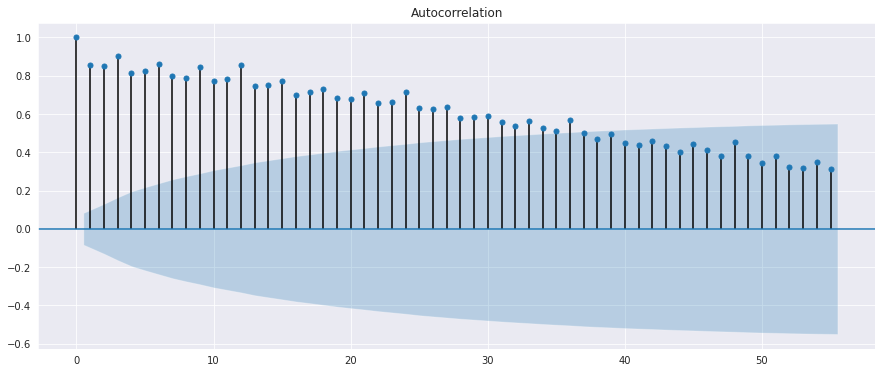

In [ ]:
plot_acf(df8.Count, lags=55);

From this plot we can see 3-month seasonality and decreasing trend.

## b
Create a training set of 486 observations, withholding a test set of 72 observations (6 years).

In [ ]:
df8_train=df8[:486]
df8_test=df8[486:]

## c
Try using various benchmark methods to forecast the training set and compare the results on the test set. Which method did best?

In [ ]:
# Adding 4 benchmark method's forecasts
df8_test=add_benchmark_methods(df8_test, df8_train.Count, df8_test.Count, 3)

In [ ]:
# Checking metrics for every method
metrics_frame(df8_test.Count, df8_test)

,SNaive,Naive,Average,Drift
MAE,10312.50,7840.28,39360.34,6967.19
MAPE,15.05,11.40,55.93,10.07
RMSE,11802.37,8940.75,39893.66,8091.30


From the metrics we can see that drift method gave the best result. Let's check it on the plot.

In [ ]:
# Visualization for the Drift method forecast
x_points=[df8_train.index[0], df8_train.index[-1]]
y_points=[df8_train.Count[0], df8_train.Count[-1]]
complex_plot(df8_train, df8_test, 'Count', 'pigs count', add_pred=True, pred=df8_test.Drift, add_drift=True, x=x_points, y=y_points)

## d
Check the residuals of your preferred method. Do they resemble white noise?

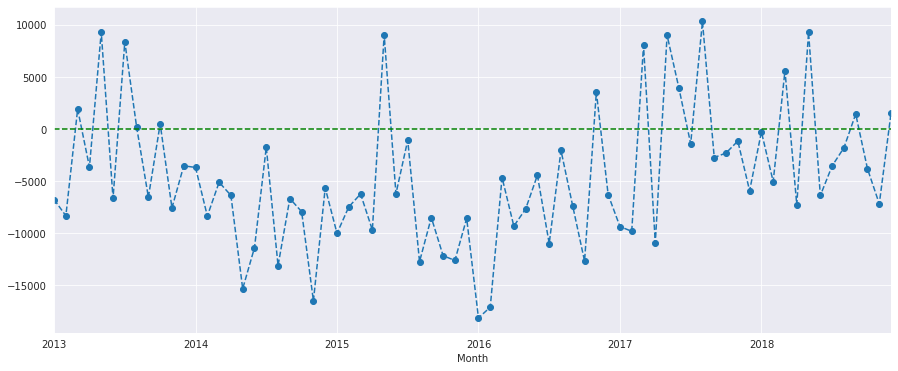

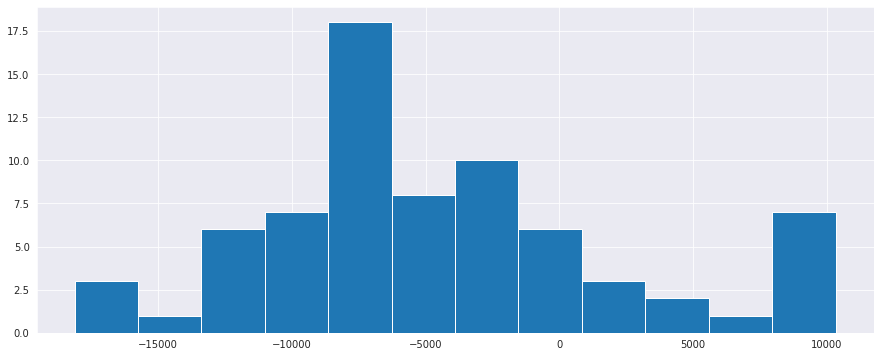

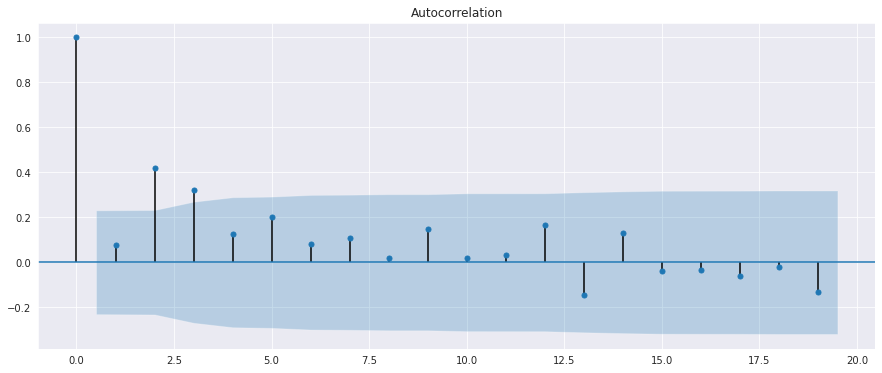

In [ ]:
# Residuals analysis for the Drift method
check_residuals(df8_test.Count, df8_test.Drift, df8_test, lags=50, bins=12)

From residuals analysis we can conclude that they do not resemble white noise because they are not randomly allocated around zero mean. And regarding autocorrelation there are 2 peaks which are outside the blue area of significance and this is not white noise behaviour, it means we still have autocorrelation.

# Ex 9

##a
Create a training set for household wealth (hh_budget) by withholding the last four years as a test set.




In [ ]:
df9=df1_d.copy()
df9_train = df9[:-4]
df9_test = df9[-4:]

##b
Fit all the appropriate benchmark methods to the training set and forecast the periods covered by the test set.

This dataset was plotted in the 1.d section so I just will check ACF plot to understand wich window for seasonal naive to use. 

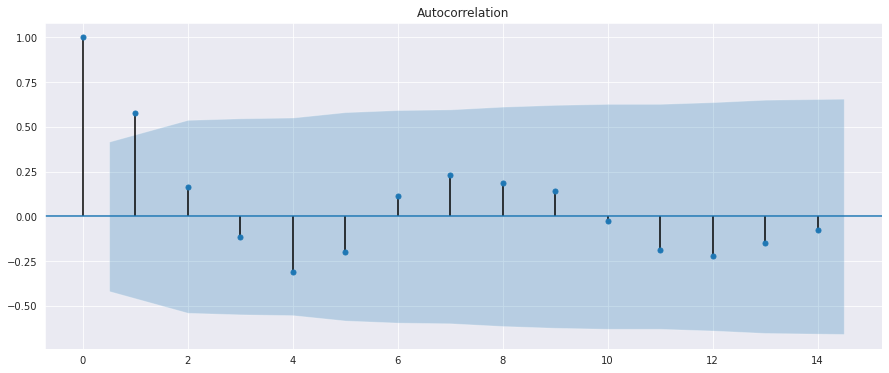

In [ ]:
plot_acf(df9.Wealth);

From this plot looks like 7 would be good seasonal window as we have second peak for 7 lag value.

In [ ]:
# Adding 4 benchmark methods
df9_test=add_benchmark_methods(df9_test, df9_train.Wealth, df9_test.Wealth, 7)

## c
Compute the accuracy of your forecasts. Which method does best?

In [ ]:
# Checking metrics for the benchmark methods
metrics_frame(df9_test.Wealth, df9_test)

,SNaive,Naive,Average,Drift
MAE,70.79,82.13,82.88,75.94
MAPE,11.84,13.75,13.88,12.72
RMSE,80.56,82.51,83.25,76.23


In [ ]:
# Visualization for the best method - seasonal naive
complex_plot(df9_train, df9_test, 'Wealth', 'household wealth', add_pred=True, pred=df9_test.SNaive)

In this case seasonal naive gave the best result but actually it depends a lot which split of train/test will be taken. We can see that seasonal naive still far away from actual and in this case all benchmark methods will give almost the same not accurate result. I assume that some decomposition or advanced models could give better results.

## d
Do the residuals from the best method resemble white noise?

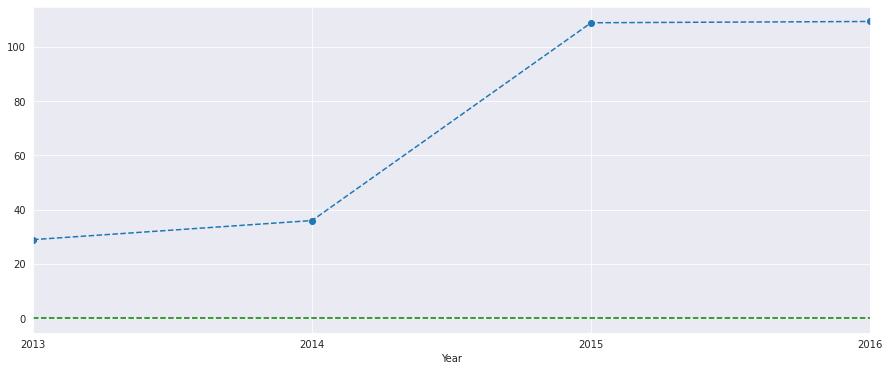

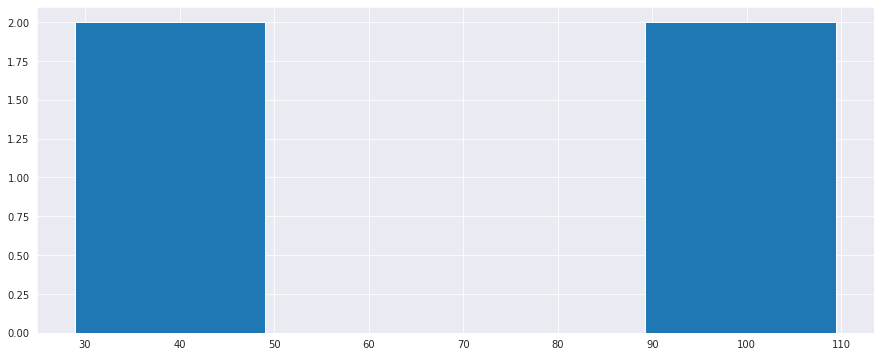

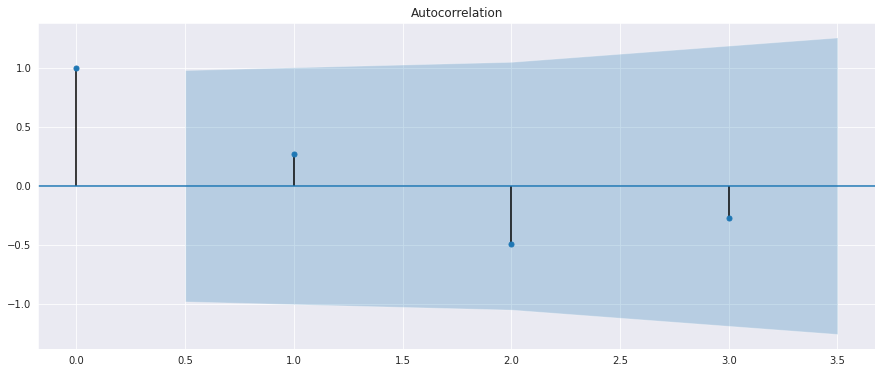

In [ ]:
# Visualization for the residuals of seasonal naive forecast
check_residuals(df9_test.Wealth, df9_test.SNaive, df9_test, lags=3, bins=4)

Checking the residuals in this case is not really useful as we have only 4 points. It is hard to understand if it is distributed normally and around zero mean. From available points we see they are on 1 side of zero. Regarding autocorrelation - we don't see it for those residuals which is good.

# Ex 10

##a
Create a training set for Australian takeaway food turnover (aus_retail) by withholding the last four years as a test set.

In [ ]:
# Creating test and train sets of data -> data is monthly so 12*4=48
df10=gr.copy()
df10_train = df10[:-48]
df10_test = df10[-48:]

##b
Fit all the appropriate benchmark methods to the training set and forecast the periods covered by the test set.


Will check ACF plot to select seasonal window

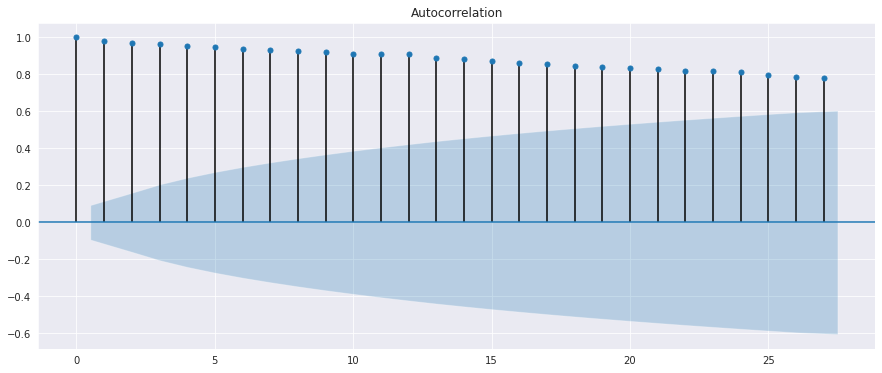

In [ ]:
plot_acf(df10.Turnover);

No obvious peaks but on 12 and 24 there are very small ones.

In [ ]:
# Adding benchmark methods 
df10_test=add_benchmark_methods(df10_test, df10_train.Turnover, df10_test.Turnover, 12)

##c
Compute the accuracy of your forecasts. Which method does best?


In [ ]:
metrics_frame(df10_test.Turnover, df10_test)

,SNaive,Naive,Average,Drift
MAE,176.67,96.37,829.41,108.12
MAPE,11.74,6.66,55.69,7.67
RMSE,192.43,118.69,837.77,130.15


We can see that Naive gave us the best result, let's check it on the plot.

In [ ]:
# Visualization for the Naive forecast
complex_plot(df10_train, df10_test, 'Turnover', 'retail turnover', add_pred=True, pred=df10_test.Naive)

From plot we can see that Naive is not really good method for this data because good method should catch increasing seasonality + trend, but within benchmark methods Naive gave the best result because seasonal naive is giving seasonal result but without upward trend and that's why it is bad. Also drift method can catch the upward trend but not seasonality (and we can see by the metrics that drift is really close to naive).

##d
Do the residuals from the best method resemble white noise?

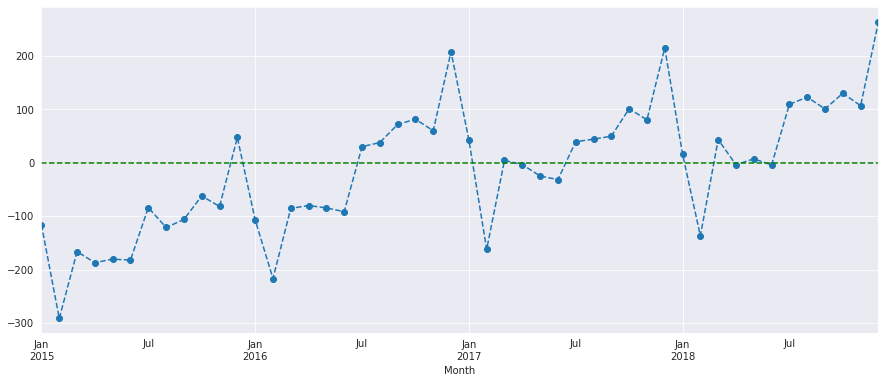

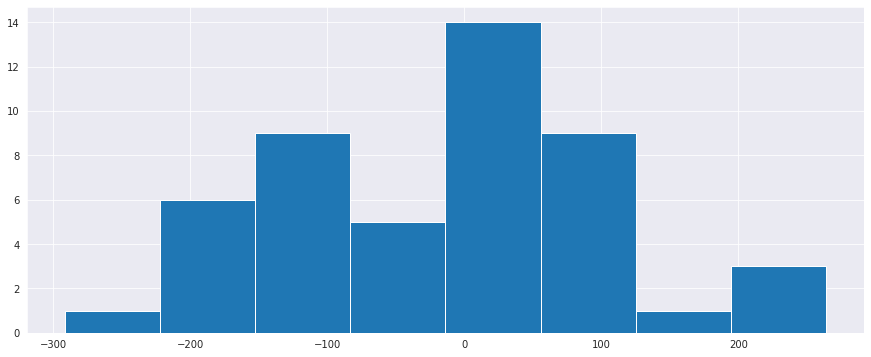

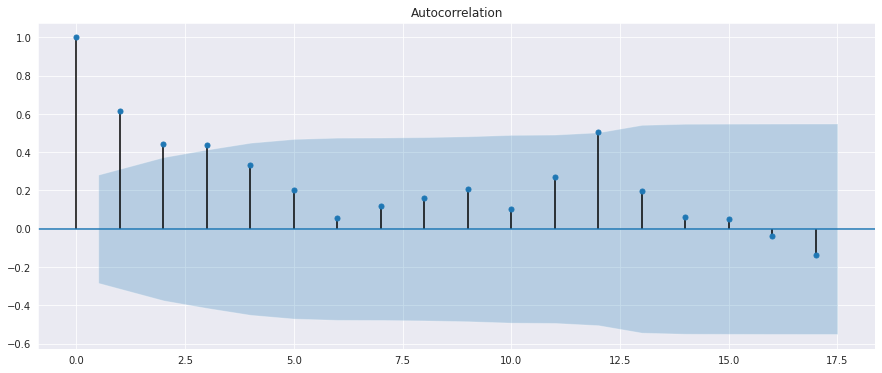

In [ ]:
# Visualization for residuals of naive method
check_residuals(df10_test.Turnover, df10_test.Naive, df10_test, bins=8)

We can definetely say that residuals don't resemble white noise because there is clear pattern on the first plot and seasonal autocorrelation on the ACF plot.

#Ex 11
We will use the Bricks data from aus_production (Australian quarterly clay brick production 1956–2005) for this exercise.

In [ ]:
df11=df1_b.copy()
plot(df11, 'Bricks', 'bricks production')

## a
Use an STL decomposition to calculate the trend-cycle and seasonal indices. (Experiment with having fixed or changing seasonality.)

First let's check ACF plot to select seasonal window.


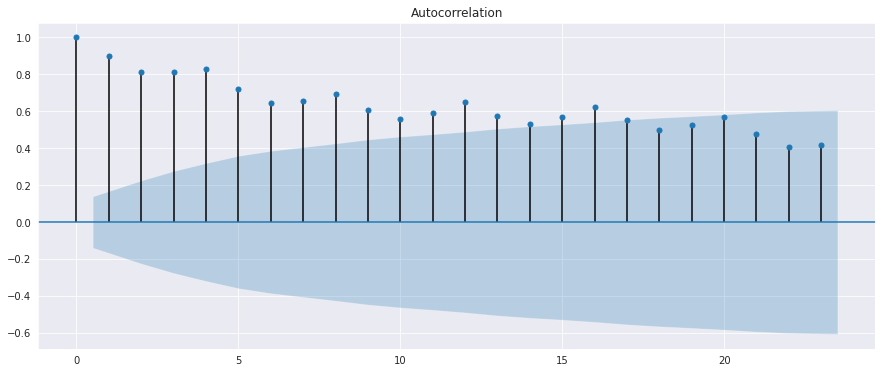

In [ ]:
# ACF plot to check seasonal autocorrelation
plot_acf(df11.Bricks);

Looks like we have yearly seasonality (4-th lags as data is quartely)

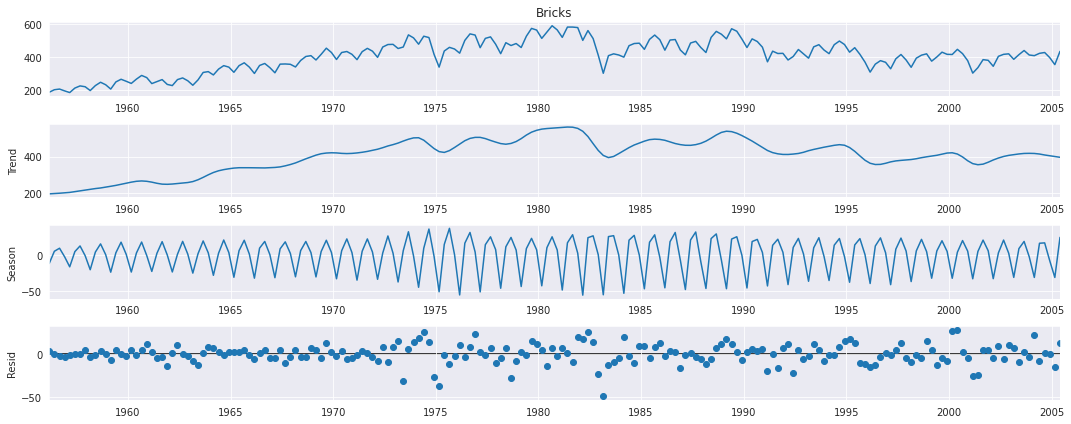

In [ ]:
# STL decomposition with seasonal window 4 -> as we have quartely data and yearly seasonality
decomp = STL(df11.Bricks, period=4).fit()
decomp.plot();

## b
Compute and plot the seasonally adjusted data.

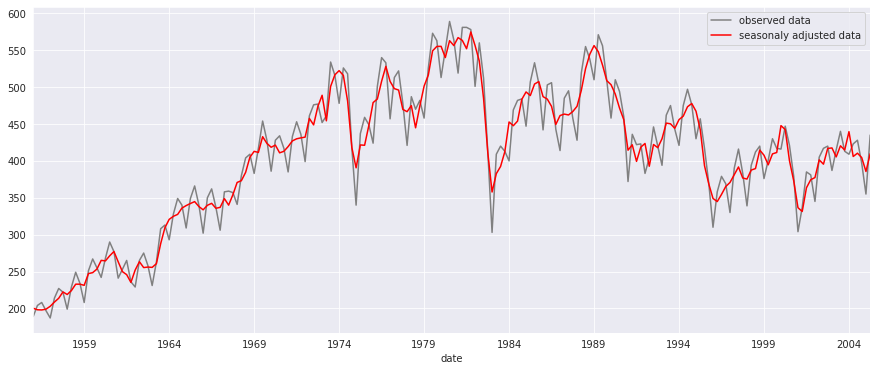

In [ ]:
# Visualization for comparing initial data and seasonaly adjusted
seas_adjusted = decomp.observed-decomp.seasonal
decomp.observed.plot(label='observed data', c='grey')
seas_adjusted.plot(label='seasonaly adjusted data', c='red')
plt.legend();

## c
Use a naïve method to produce forecasts of the seasonally adjusted data.

I need to use last 2 years of data as test because later there is exercise to compare with SNaive where test is set as 2 years.

In [ ]:
# Creating train/test frames of seasonaly adjusted data
seas_adjusted=pd.DataFrame(seas_adjusted)
seas_adjusted.rename(columns={0:'Actual'}, inplace=True)
seas_adjusted_test=seas_adjusted[-8:]
seas_adjusted_train=seas_adjusted[:-8]

# Producing the Naive forecast of seasonaly adjusted data and plotting the result
seas_adjusted_test['Naive']=seas_adjusted_train.Actual[-1]
complex_plot(seas_adjusted_train, seas_adjusted_test, 'Actual', 'seasonaly adjusted bricks production', add_pred=True, pred=seas_adjusted_test.Naive)

## d
Use decomposition_model() to reseasonalise the results, giving forecasts for the original data.

To have the same result as decomposition_model() reseasonalised forecast will be calculated.

In [ ]:
# Summarizing Naive forecast of seasonaly adjusted data and seasonal component
seas_adjusted_test['seasonal_component']= decomp.seasonal[-8:]
seas_adjusted_test['reseasonalised']=seas_adjusted_test.Naive+seas_adjusted_test.seasonal_component

# Checking metrics and plotting the result
print_metrics(df11.Bricks[-8:], seas_adjusted_test.reseasonalised)
complex_plot(df11[:-8], df11[-8:], 'Bricks', 'bricks production', add_pred=True, pred=seas_adjusted_test.reseasonalised)

MAPE: 2.77
MAE: 11.15
RMSE: 15.49


Metrics and visualization look good enough as for such simple method. Let's check the residuals.

## e
Do the residuals look uncorrelated?

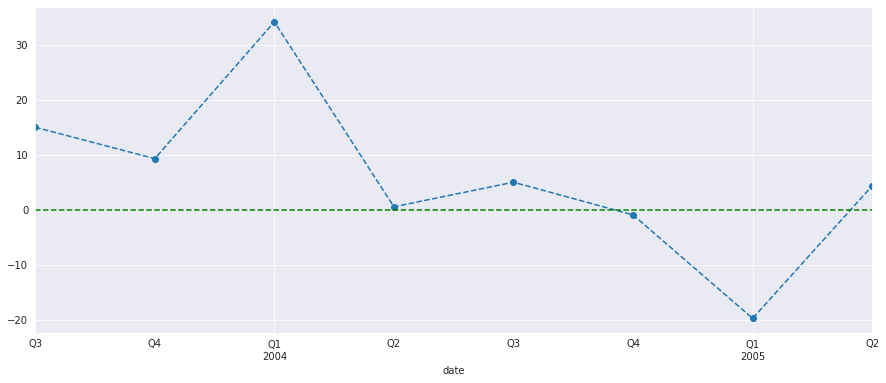

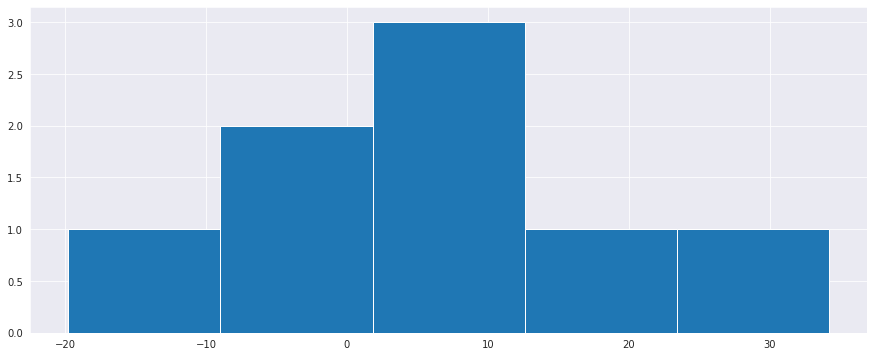

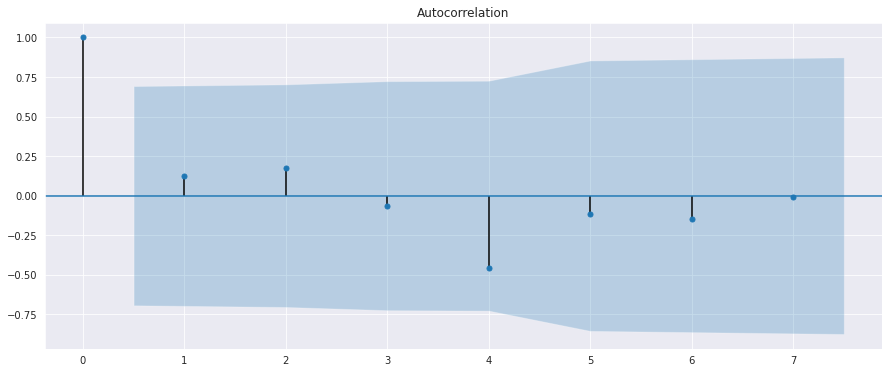

In [ ]:
# Visualization for residuals anlysis
check_residuals(df11.Bricks[-8:], seas_adjusted_test.reseasonalised, seas_adjusted_test, lags=15, bins=5)

Allocation around zero - there are points on both sides but hard to say if there is any pattern or not. Histogram is not as for normal distribution. And regarding autocorrelation - all is good, residuals are not autocorrelated. Let's compare with robust STL decomposition.

## f
Repeat with a robust STL decomposition. Does it make much difference?

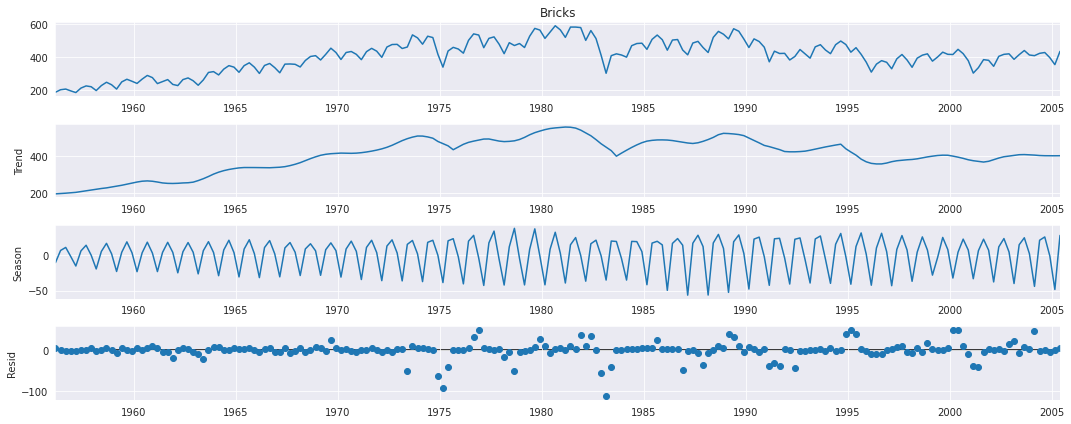

In [ ]:
# STL decomposition with seasonal window 4 -> as we have quartely data and yearly seasonality
decomp = STL(df11.Bricks, period=4, robust=True).fit()
decomp.plot();

For robust STL decomposition we can see that on residuals plot points are more close to zero, because using robust estimation allows the model to tolerate larger errors.

Let's repeat all the same steps with robust STL.

In [ ]:
seas_adjusted=pd.DataFrame(seas_adjusted)
seas_adjusted.rename(columns={0:'Actual'}, inplace=True)
seas_adjusted_test=seas_adjusted[-8:]
seas_adjusted_train=seas_adjusted[:-8]
seas_adjusted_test['Naive']=seas_adjusted_train.Actual[-1]
complex_plot(seas_adjusted_train, seas_adjusted_test, 'Actual', 'seasonaly adjusted bricks production', add_pred=True, pred=seas_adjusted_test.Naive)

Naive forecast for seasonaly adjusted data of robust STL decomposition looks the same as for not robust.

In [ ]:
# Checking metrics and plotting the result for reseasonalised forecast
seas_adjusted_test['seasonal_component']= decomp.seasonal[-8:]
seas_adjusted_test['reseasonalised']=seas_adjusted_test.Naive+seas_adjusted_test.seasonal_component
print_metrics(df11.Bricks[-8:], seas_adjusted_test.reseasonalised)
complex_plot(df11[:-8], df11[-8:], 'Bricks', 'bricks production', add_pred=True, pred=seas_adjusted_test.reseasonalised)

MAPE: 2.45
MAE: 10.11
RMSE: 17.64


Here we can see that MAE and MAPE are slightly better for robust but RMSE is a little bit worth. It can be explained because with robust forecast become better for last year (where we have bigger magnitude) and worth for first year. But generally there is no significant difference in this case for robust/not robust. 

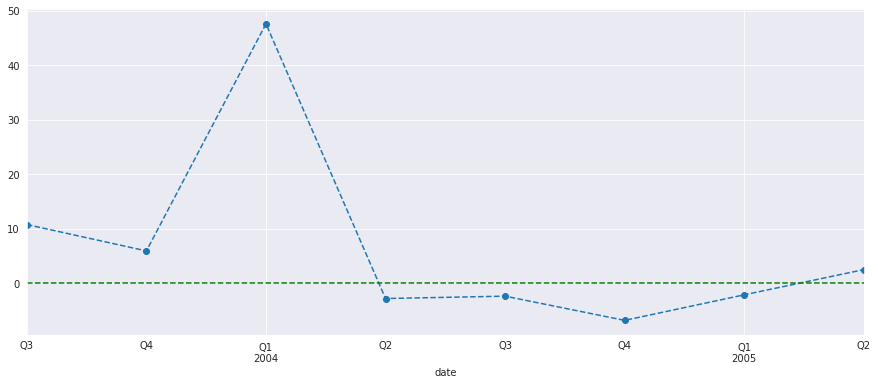

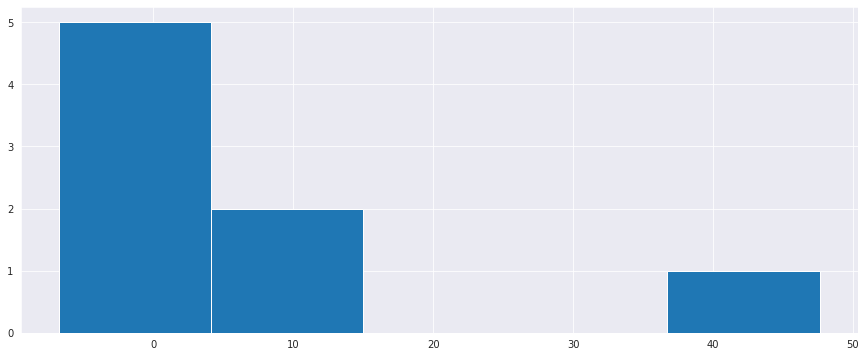

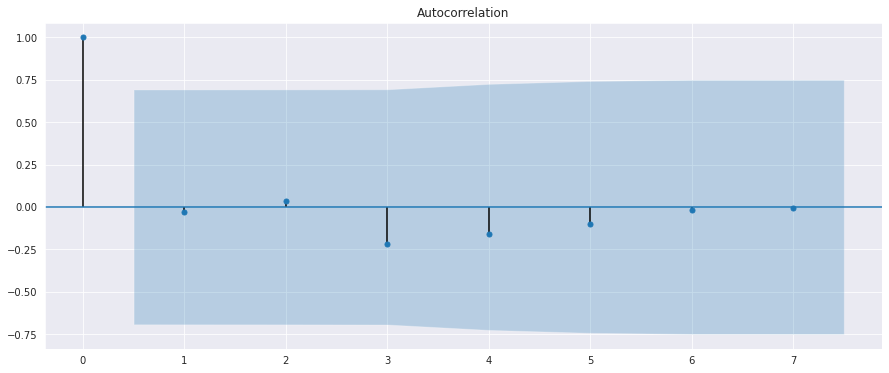

In [ ]:
# Visualization for residuals analysis
check_residuals(df11.Bricks[-8:], seas_adjusted_test.reseasonalised, seas_adjusted_test, lags=15, bins=5)

From residuals perspective also nothing changed a lot, still no autocorrelation which is good, but no proper allocation around zero mean.

## g
Compare forecasts from decomposition_model() with those from SNAIVE(), using a test set comprising the last 2 years of data. Which is better?

In [ ]:
# Adding seasonal naive forecast with 4 as seasonal window (the same as in STL)
seas_adjusted_test=add_snaive_forecast(seas_adjusted_test, df11.Bricks[:-8], 4, len(df11.Bricks[-8:]))

In [ ]:
# Checking metrics and visualization for Seasonal naive method
print_metrics(df11.Bricks[-8:], seas_adjusted_test.SNaive)
complex_plot(df11[:-8], df11[-8:], 'Bricks', 'bricks production', add_pred=True, pred=seas_adjusted_test.SNaive)

MAPE: 4.52
MAE: 18.25
RMSE: 20.0


As we can see this forecast is better for first year and worth for second. But as error for second year is bigger - we have better metrics with STL decomposition. Let's check the residuals.

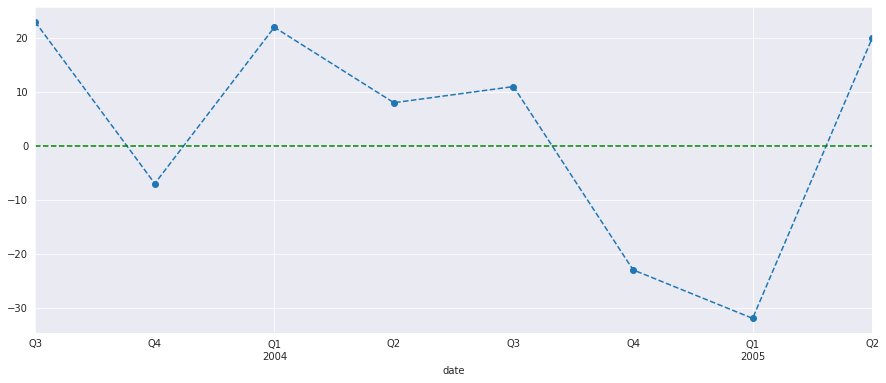

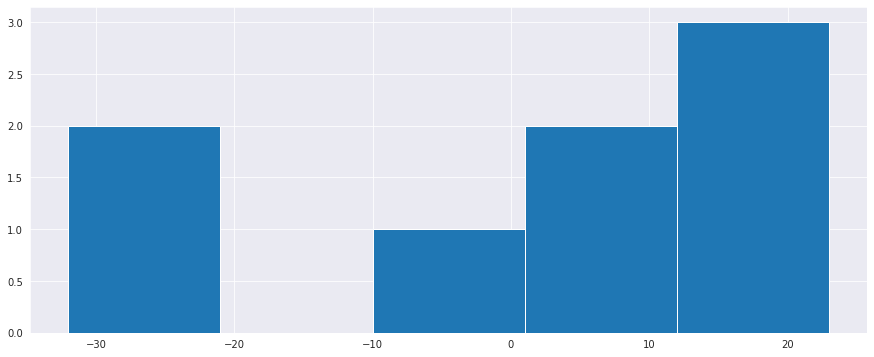

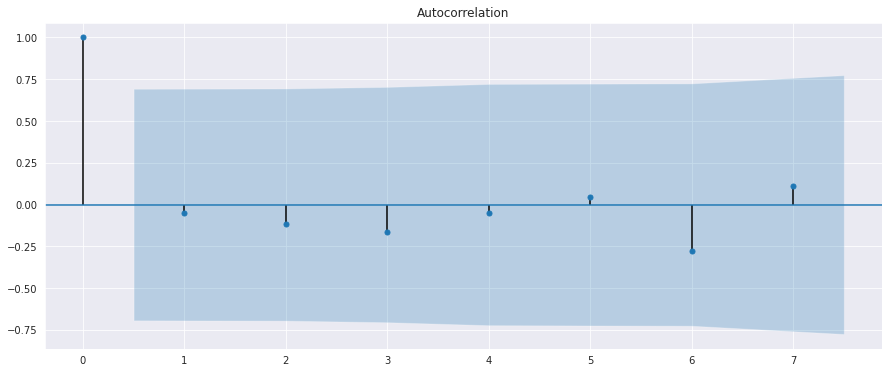

In [ ]:
# Visualization for residuals analysis
check_residuals(df11.Bricks[-8:], seas_adjusted_test.SNaive, seas_adjusted_test, lags=15, bins=5)

Residuals are not correlated and have better distribution around the zero mean, but it is hard to say that this model is better. Metrics show us that for 2 years of prediction STL decomposition is better.

#Ex 12

tourism contains quarterly visitor nights (in thousands) from 1998 to 2017 for 76 regions of Australia.

In [ ]:
# Reading the data and setting datetime index
df12 = load_data("tourism")
df12=replace_quarters_to_date_index(df12, df12.Quarter)
df12

,Quarter,Region,State,Purpose,Trips,years,quarters
date,,,,,,,
1998-03-01,1998 Q1,Adelaide,South Australia,Business,135.077690,1998,03
1998-06-01,1998 Q2,Adelaide,South Australia,Business,109.987316,1998,06
1998-09-01,1998 Q3,Adelaide,South Australia,Business,166.034687,1998,09
1998-12-01,1998 Q4,Adelaide,South Australia,Business,127.160464,1998,12
1999-03-01,1999 Q1,Adelaide,South Australia,Business,137.448533,1999,03
...,...,...,...,...,...,...,...
2016-12-01,2016 Q4,Yorke Peninsula,South Australia,Visiting,33.672151,2016,12
2017-03-01,2017 Q1,Yorke Peninsula,South Australia,Visiting,46.223014,2017,03
2017-06-01,2017 Q2,Yorke Peninsula,South Australia,Visiting,50.582837,2017,06


## a
Extract data from the Gold Coast region using filter() and aggregate total overnight trips (sum over Purpose) using summarise(). Call this new dataset gc_tourism.

In [ ]:
# Filtering the data
df12=df12[df12.Region=='Gold Coast'][['Region', 'Purpose', 'Trips']]

Here I wasn't sure what does it mean sum over Purpose because if to group by Purpose we will not have time series anymore

In [ ]:
# Grouping an sorting the Trips values
gc_tourism= df12.groupby('Purpose').sum()
gc_tourism

,Trips
Purpose,
Business,7097.480557
Holiday,42267.190473
Other,1698.130789
Visiting,19340.956297


So I did grouping by date to have "aggregate total overnight trips"

In [ ]:
# Grouping and plotting the time series
gc_tourism = df12.groupby(level=0).sum()
plot(gc_tourism, 'Trips', 'trips count')

## b
Using slice() or filter(), create three training sets for this data excluding the last 1, 2 and 3 years. For example, gc_train_1 <- gc_tourism %>% slice(1:(n()-4))

So basically horizon of forecast(test data) always will be 1 last year (next condition in exercise) and training set is changing due to slicing.

In [ ]:
gc_train_1 = gc_tourism[:-4]
gc_train_2 = gc_tourism[:-8]
gc_train_3 = gc_tourism[:-12]

gc_test_1 = gc_tourism[-4:]
gc_test_2 = gc_tourism[-8:-4]
gc_test_3 = gc_tourism[-12:-8]

## c
Compute one year of forecasts for each training set using the seasonal naïve (SNAIVE()) method. Call these gc_fc_1, gc_fc_2 and gc_fc_3, respectively.

Seasonal window was selected 4 because we have yearly seasonality and quartely data.

In [ ]:
gc_fc_1=seasonal_naive_forecast(gc_train_1.Trips, 4, 4)
gc_fc_2=seasonal_naive_forecast(gc_train_2.Trips, 4, 4)
gc_fc_3=seasonal_naive_forecast(gc_train_3.Trips, 4, 4)

## d
Use accuracy() to compare the test set forecast accuracy using MAPE. Comment on these.

For every test set Mape is calculated and plotting is produced

In [ ]:
gc_fc_1 = pd.DataFrame(gc_fc_1).set_index(gc_test_1.index)
gc_test_1['Pred']=gc_fc_1
mape1=mean_absolute_percentage_error(gc_test_1.Trips, gc_test_1.Pred)
print("MAPE = ", round(mape1, 2))
complex_plot(gc_train_1, gc_test_1, 'Trips', 'Number_1 split', pred=gc_test_1.Pred, add_pred=True)

MAPE =  15.06


In [ ]:
gc_fc_2 = pd.DataFrame(gc_fc_2).set_index(gc_test_2.index)
gc_test_2['Pred']=gc_fc_2
mape2=mean_absolute_percentage_error(gc_test_2.Trips, gc_test_2.Pred)
print("MAPE = ", round(mape2, 2))
complex_plot(gc_train_2, gc_test_2, 'Trips', 'Number_2 split', pred=gc_test_2.Pred, add_pred=True)

MAPE =  4.32


In [ ]:
gc_fc_3 = pd.DataFrame(gc_fc_3).set_index(gc_test_3.index)
gc_test_3['Pred']=gc_fc_3
mape3=mean_absolute_percentage_error(gc_test_3.Trips, gc_test_3.Pred)
print("MAPE = ", round(mape3, 2))
complex_plot(gc_train_3, gc_test_3, 'Trips', 'Number_3 split', pred=gc_test_3.Pred, add_pred=True)

MAPE =  9.07


As we can see for the second split the metrics and visualization are the best. It can be explained by the data which is used in train set before test set. In second split last year of train set is the most similar to test year, but in other splits it's not so similar. So basically for this method only 1 year before forecast horizon matters.

# Task 2 -> Residuals analysis 

Follow along with this Residual Diagnostics example from the MATLAB docs with any dataset you've previously worked with; for the models to compare, use the naive method (random walk) and seasonal decomposition.

For analysis I selected tourism dataset from previous exercise. As test set last 5 years of quartely data were taken.

In [ ]:
train=gc_tourism[:-20]
test=gc_tourism[-20:]
test.head()

,Trips
date,
2013-03-01,968.307964
2013-06-01,831.202650
2013-09-01,837.346973
2013-12-01,870.192238
2014-03-01,996.040289


First will add naive forecast to the dataframe

In [ ]:
# Naive forecast and it's visualization
test=add_naive_forecast(test, train.Trips)
test['Naive_residuals']=test.Trips-test.Naive
print_metrics(test.Trips, test.Naive)
complex_plot(train, test, 'Trips', 'trips count', pred=test.Naive, add_pred=True)

MAPE: 12.39
MAE: 108.31
RMSE: 123.85


After that prediction with seasonal decomposition will be added. It follows the same steps as in exercise 11:
* STL decomposition with 4 as period (yearly seasonality, quartely data)
* Naive forecast for seasonaly adjusted data
* Reseasonalised forecast
* Calculating the residuals between the model's predictions and actuals trips count

In [ ]:
# STL decomposition with seasonal window 4 -> as we have quartely data and yearly seasonality
decomp = STL(train.Trips, period=4).fit()
seas_adjusted = decomp.observed-decomp.seasonal
test['Seas_adj_Naive']=seas_adjusted[-1]
seasonal=pd.DataFrame(decomp.seasonal[-20:]).set_index(test.index)
test['seasonal_component']=seasonal.season
test['reseasonalised']=test['Seas_adj_Naive']+test.seasonal_component
test['Decomp_residuals']=test.Trips-test.reseasonalised

In [ ]:
# Metrics and visualizaion for seasonal decomposition method
print_metrics(test.Trips, test.reseasonalised)
complex_plot(train, test, 'Trips', 'trips count', add_pred=True, pred=test.reseasonalised)

MAPE: 6.55
MAE: 62.4
RMSE: 87.25


From the plot and metrics seasonal decomposition is giving much better result then simple naive method, but in this task most attention is around residuals analysis.

## Residual plots


In previous tasks function for plotting residuals, their histogram and ACF plot was created, so will use it here.

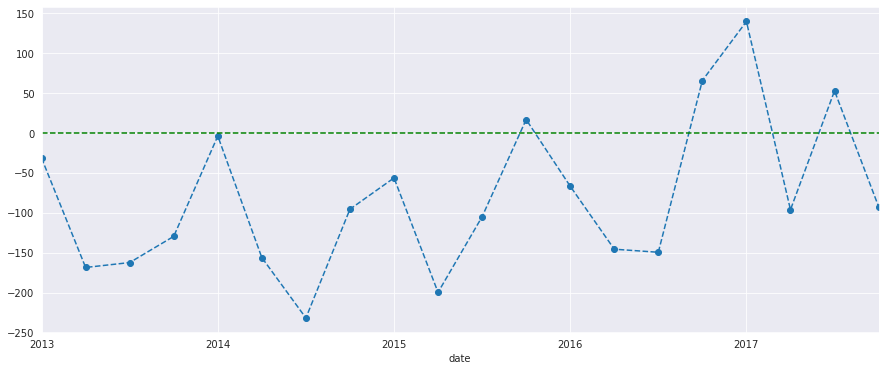

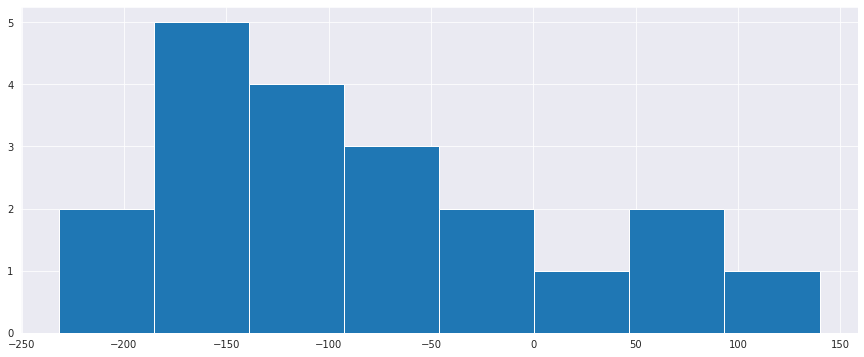

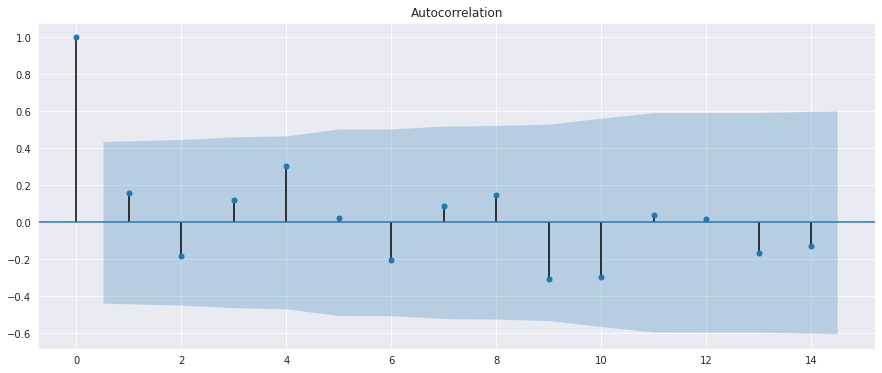

In [ ]:
# Visualization for Naive residuals
plot_residual_analysis(test.Naive_residuals, lags=10, bins=8)

**Naive residuals**
* From the plots we can see that on first one residuals are not really randomly located around mean zero. Some bias is present and points are located more on negative side of plot. 
* Also some amount of heteroscedasticity is apparent, though it is difficult for a visual assessment to separate this from random variation in such a small sample.
* Histogram is not as for normal distribution but more investogation regarding distribution will be done
* There is no evidence of autocorrelation outside of the Bartlett two-standard-error bands for white noise, given by the blue lines. So we can say residuals are not correlated. But more tests will be done.

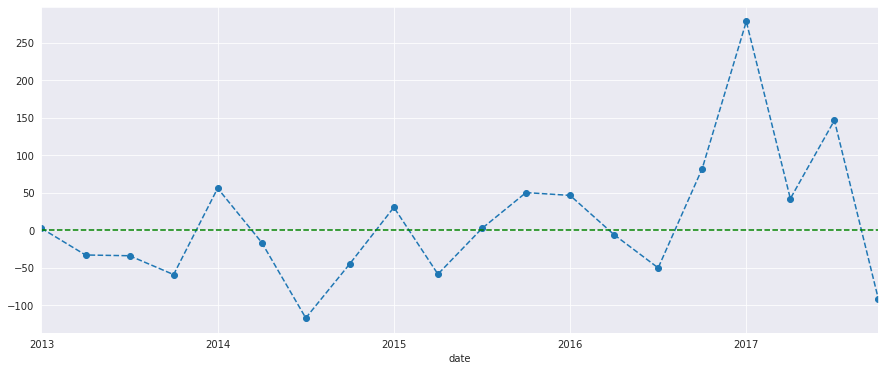

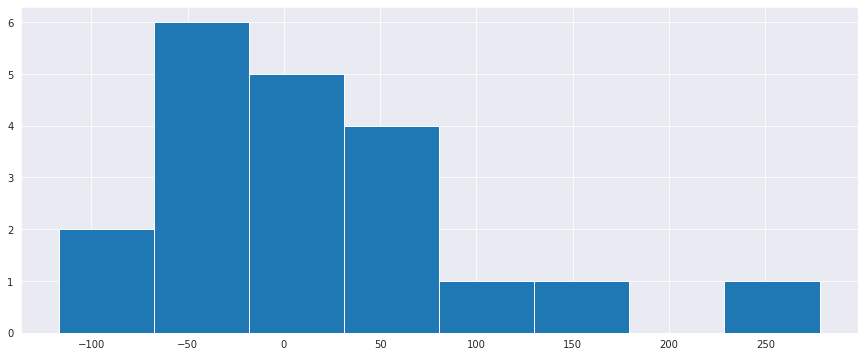

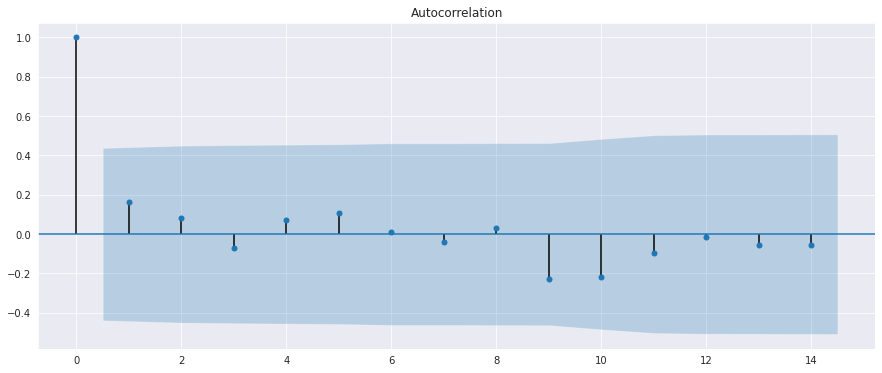

In [ ]:
# Visualization for Decomposition residuals
plot_residual_analysis(test.Decomp_residuals, lags=10, bins=8)

**Seasonal decomposition residuals**
* From the plots we can see that on first one residuals are located around mean zero. This plot looks better with almost no bias comparing to Naive residuals.
* Heteroscedasticity and histogram are the same as for Naive but more investigation will be done.
* There is no evidence of autocorrelation outside of the Bartlett two-standard-error bands for white noise, given by the blue lines. So we can say residuals are not correlated. But if to compare autocorrelation within blue lines then for Naive it is bigger (0.4) then for Seasonal decomposition (0.2).
* Let's compare autocorrelation with Durbin-Watson test

## Autocorrelation tests

In [ ]:
# Using statsmodels.durbin_watson() method for checking autocorrelation
print('Durbin-Watson test result for Naive residuals ', round(durbin_watson(test.Naive_residuals), 3))
print('Durbin-Watson test result for Seasonal decomposition residuals ', round(durbin_watson(test.Decomp_residuals), 3))

Durbin-Watson test result for Naive residuals  0.956
Durbin-Watson test result for Seasonal decomposition residuals  1.573


* The Durban Watson statistic will always assume a value between 0 and 4. A value of DW = 2 indicates that there is no autocorrelation. When the value is below 2, it indicates a positive autocorrelation, and a value higher than 2 indicates a negative serial correlation.
* In our case smaller autocorrelation is for Seasonal decomposition as 1.573 value is closer to 2. So it corresponds to the previous statements that autocarrelation for Naive residuals is bigger and is positive.
* Econometricians have traditionally relied on a rule of thumb that a Durbin-Watson statistic below about 1.5 is reason to suspect positive first-order autocorrelation, so for Seasonal decomposition there is no autocorrelation of the residuals.

The Durban Watson takes into account first-order autocorrelation and has assumption of normal distribution. that's why in our case it is good to check also Ljung-Box Q-test, which tests for "overall" or "portmanteau" lack of autocorrelation. That's means taking lags into account.

In [ ]:
# Perform the Ljung-Box test
print('\nP-values for Ljung-Box test of Naive residuals are:\n ', acorr_ljungbox(test.Naive_residuals, lags=10)[1])
print('\nP-values for Ljung-Box test of Seasonal decomposition residuals are:\n ', acorr_ljungbox(test.Decomp_residuals, lags=10)[1])


P-values for Ljung-Box test of Naive residuals are:
  [0.438875   0.49604439 0.62023763 0.36167209 0.49945154 0.46089142
 0.54591414 0.56473272 0.31573761 0.15713447]

P-values for Ljung-Box test of Seasonal decomposition residuals are:
  [0.42896876 0.6751829  0.82153336 0.90097023 0.92473532 0.96579728
 0.98377054 0.99292264 0.93660455 0.83946856]


As we can see all the p-values are bigger then 0.05 wich means we reject Null Hypothesis(no autocorrelation) and autocorrelation is present in both cases.

One of the shortcoming of the Ljung-Box Q-test is that the default chi-square distributions used by the test are asymptotic, and can produce unreliable results in small samples. And we have not very big sample.

Another test for "overall" lack of autocorrelation is a runs test, which determines if the signs of the residuals deviate systematically from zero.

In [ ]:
# Perform the Runs test
print('P-value for Runs test of Naive residuals : ', runstest_1samp(test.Naive_residuals)[1])
print('P-value for Runs test of Seasonal decomposition residuals : ', runstest_1samp(test.Decomp_residuals)[1])

P-value for Runs test of Naive residuals :  0.6659215900173632
P-value for Runs test of Seasonal decomposition residuals :  0.5977096403451079


Here also in both cases we fail to reject Null Hypothesis that residuals are random.

So conclusion from tests regarding residuals is next: most probably residuals are autocorrelated for both models. So it differs from ACF plots results. But maybe it is because of small amount of test samples, I'm not sure.

## Heteroscedasticity 

Usually to check if heteroscedasticity is present fitted vs residuals plot are used.


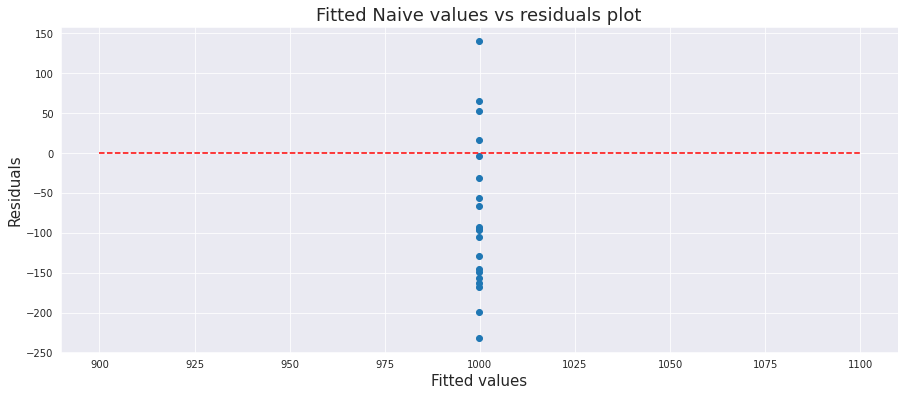

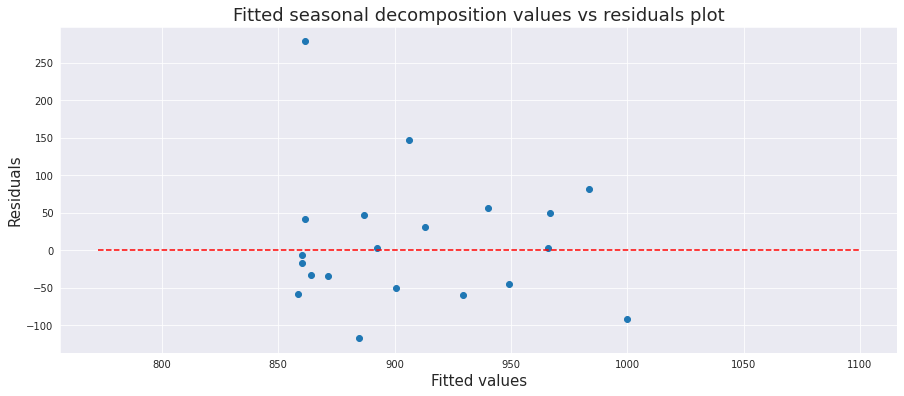

In [ ]:
scatter_fitted_vs_residuals(test.Naive, test.Naive_residuals, 'Naive values')
scatter_fitted_vs_residuals(test.reseasonalised, test.Decomp_residuals, 'seasonal decomposition values')

For Naive residuals this plot doesn't make any sense as all naive values are the same. For Seasonal decomposition residuals it's hard to say if heteroscedasticity is really present because only one point which can confirm this looks like an outlier.

We can check heteroscedasticity with ARCH test. Here Null Hypothesis is that a series of residuals exhibits no conditional heteroscedasticity (ARCH effects).

In [ ]:
print('P-value of ARCH test for Naive residuals: ', het_arch(test.Naive_residuals)[1])
print('P-value of ARCH test for Seasonal decomposition residuals: ', het_arch(test.Decomp_residuals)[1])

P-value of ARCH test for Naive residuals:  0.4208665733596656
P-value of ARCH test for Seasonal decomposition residuals:  0.8573685218968317


And we can confirm that there are no conditional heteroscedasticity in both cases as p-values are bigger then 0.05.

## Distribution

A normal probability plot of the residual series gives a quick assessment:

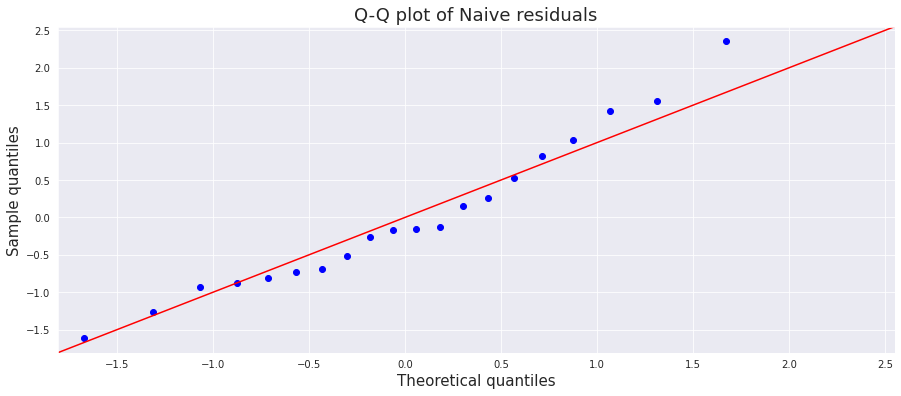

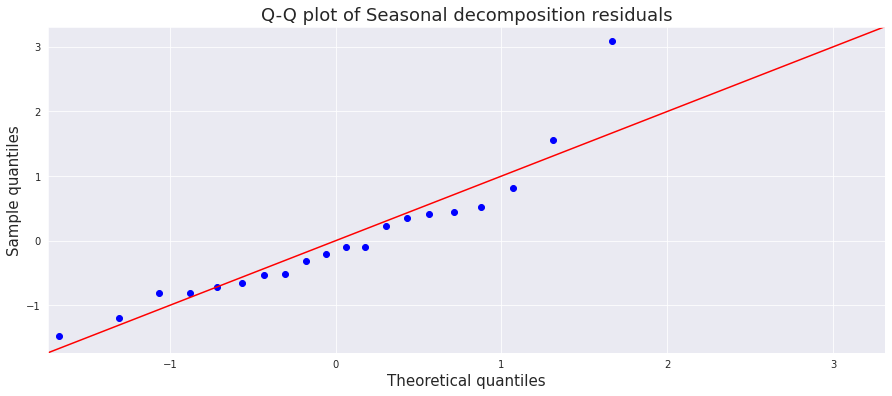

In [ ]:
qq_plot(test.Naive_residuals, 'Naive')
qq_plot(test.Decomp_residuals, 'Seasonal decomposition')

Here we can see some departure from normality for Seasonaly decomposition residuals, indicating that the distributions may be skewed. But here we most probably have outlier so removing it can improve the normality.

Aslo we can check normality with Lilliefors test which espessially useful for small samples. Null hypothesis is that the sample comes from a normal distribution.

In [ ]:
print('P-value of Lilliefors test for Naive residuals: ', lilliefors(test.Naive_residuals)[1])
print('P-value of Lilliefors test for Seasonal decomposition residuals: ', lilliefors(test.Decomp_residuals)[1])

P-value of Lilliefors test for Naive residuals:  0.3072125309621098
P-value of Lilliefors test for Seasonal decomposition residuals:  0.2180371707465929


We cannot reject Null hypothesis and probably distribution of the residuals is close to normal. 

**Conclusion of residuals analysis:**
From a forecasting perspective, if a model has successfully represented all of the systematic information in the data, then the residuals should be white noise. But in our cases for Naive and Seasonal decomposition models residuals are not white noise. It means the models can be improved and more information regarding patterns from data can be obtained.

# Task 3 -> Kaggle dataset
Take the following Kaggle dataset: Nepalese Large Cardamom Forecasting Data (combined_data.csv). Tidy up the data. Devise a validation scheme for prediction, including actually splitting the dataset. Use an average as your forecast method. Calculate several metrics of your forecast and choose the one that makes the most sense.



In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/LesiaR/Datasets-base/main/combined_data.csv')
df

,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1961,1961.1,ha,Unnamed: 7,M,Year,Production
0,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1962,1962,ha,NaN,M,1961.0,280.0
1,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1963,1963,ha,NaN,M,1962.0,290.0
2,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1964,1964,ha,NaN,M,1963.0,300.0
3,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1965,1965,ha,NaN,M,1964.0,310.0
4,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1966,1966,ha,NaN,M,1965.0,320.0
...,...,...,...,...,...,...,...,...,...,...,...
138,Nepal,"Nutmeg, mace and cardamoms",5510,Production,2012,2012,tonnes,6026.0,NaN,NaN,NaN
139,Nepal,"Nutmeg, mace and cardamoms",5510,Production,2013,2013,tonnes,7000.0,NaN,NaN,NaN
140,Nepal,"Nutmeg, mace and cardamoms",5510,Production,2014,2014,tonnes,5225.0,NaN,NaN,NaN
141,Nepal,"Nutmeg, mace and cardamoms",5510,Production,2015,2015,tonnes,5166.0,NaN,NaN,NaN


For this dataset I've noticed 2 columns with values in tonnes but they are in different parts of the frame, so let's plot them.

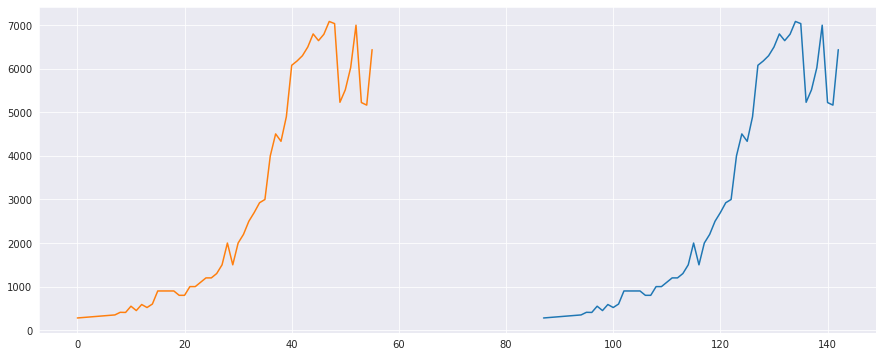

In [ ]:
df1=df[df['Area harvested']=='Production']
df1['Unnamed: 7'].plot()
df.Production.plot();

As we can see this are the same values just we need to add corresponding year here. All other columns don't make any sence from time series point of view. 

In [ ]:
# Filtering and cleaning the data
df=df[['Year', 'Production']]
df.dropna(inplace=True)
df.Year=pd.to_datetime(df.Year.astype(int), format='%Y')
df.set_index('Year', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 1961-01-01 to 2016-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  56 non-null     float64
dtypes: float64(1)
memory usage: 896.0 bytes


In [ ]:
plot(df, 'Production', 'cardamoms production')

As we can see from the plot cardamoms production is on high level for last years if to compare with period before 1998. So I think if we have 1-2 years as horizon of prediction and model is average then data before 1998 shouldn't be used into train/test split.

In [ ]:
# Filtering the data after 1997 year
df=df[df.index.year>1997]

So to do train/test split I just created 5 sets where tests are last 2 years within 10 years from 2077 to 2016. Actually it is more correct to have only 1 year but I took 2 years to be able to demonstrate this split on the plot below.

In [ ]:
# time series split os the data on train and test
train_data = []
test_data = []
for i in range(1, 6):
    train_data.append(df[:-2*i])
    test = (df[-2*i:])
    test_data.append(test[:2])

In [ ]:
# Visualization for train/test split
for i in range(0, 5):  
  complex_plot(train_data[i], test_data[i], 'Production', f'Number_{i+1} split');

Now average prediction will be produced for every test set and basic metrics calculated.

In [ ]:
for i in range(0, 5):
  average = train_data[i].Production.mean()
  test_data[i]['Average']=average

In [ ]:
for i in range(0, 5):
  print('\nSplit', i+1)
  print_metrics(test_data[i].Production, test_data[i].Average)


Split 1
MAPE: 11.5
MAE: 636.5
RMSE: 669.27

Split 2
MAPE: 14.55
MAE: 887.5
RMSE: 895.17

Split 3
MAPE: 4.68
MAE: 258.58
RMSE: 362.81

Split 4
MAPE: 14.75
MAE: 903.0
RMSE: 911.31

Split 5
MAPE: 16.3
MAE: 1134.0
RMSE: 1143.49


From metrics we can see that all of them are decreasing and increasing correspondly, so MAPE can be used for comparing the model as it is more interpretable in this case. Also we don't have zero values in the sets so it can be safely used.

In the end we are taking the mean of all splits results and then can do conclusions regarding the model.

In [ ]:
mape_all=[]
for i in range(0, 5):
  mape = mean_absolute_percentage_error(test_data[i].Production, test_data[i].Average)
  mape_all.append(mape)

print('MAPE of 5 splits:', round(mean(mape_all), 3))

MAPE of 5 splits: 12.356


In our case MAPE is very big so we need to use improved models and leave average method only as the benchmark.